#Import and config

In [ ]:
import random
import numpy as np
import pandas as pd
import time
import os

from math import ceil

from tqdm import tqdm
from tabulate import tabulate
import matplotlib.pyplot as plt
from fastprogress import master_bar, progress_bar
from collections import OrderedDict


import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.models.feature_extraction import create_feature_extractor

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay ,classification_report , accuracy_score


from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
root_dir = '/content/drive/My Drive/ADDNN/Hw03/'
model_config_dir = os.path.join(root_dir , 'config')
model_fig_dir = os.path.join(root_dir , 'fig')

In [ ]:
# os.makedirs(model_config_dir , exist_ok=True)
os.makedirs(model_fig_dir , exist_ok=True)

# data

## Hyper_parameters

In [ ]:
BATCH_SIZE_TRAIN = 128
BATCH_SIZE_TEST= 128
BATCH_SIZE_VAL= 128

train_percentage  = 0.8
test_percentage  = 0.2


## utils

In [ ]:
def train_val_dataset(dataset, val_split=0.25):
    """Splitting the dataset into two parts"""
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=val_split ,stratify=dataset.targets)
    datasets = {}
    datasets['train'] = torch.utils.data.Subset(dataset, train_idx)
    datasets['val'] = torch.utils.data.Subset(dataset, val_idx)
    return torch.utils.data.Subset(dataset, train_idx) , torch.utils.data.Subset(dataset, val_idx)

In [ ]:
def get_CIFAR10(reduce_trans=False):

    # setting proper transformation to be applied on the data before feeding to the network for each train/test/val phase
    preprocess =  transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
                ])

    if reduce_trans:
      augmentation = transforms.Compose(
                      [transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                      transforms.ToTensor(),
                      transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))])
    else:
      augmentation = transforms.Compose(
                      [transforms.RandomHorizontalFlip(),
                      transforms.RandomRotation(15),
                      transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                      transforms.ToTensor(),
                      transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))])

    transform = {'train' :augmentation,
                'val' : preprocess,
                'test' : preprocess
                }

    # downloding the CIFAR100 dataset and loading it to the root for train and test dataset
    train_dataset = datasets.CIFAR10(
        root="data",
        train=True,
        download=True,
        transform=transform['train']
    )

    test_dataset = datasets.CIFAR10(
        root="data",
        train=False,
        download=True,
        transform=transform['test']
    )

    # splitting the downloaded train dataset to train and validation dataset
    train_dataset , val_dataset = train_val_dataset(train_dataset)

    return train_dataset ,val_dataset , test_dataset


In [ ]:
def sample_from_dataset(dataset, sample_size, random_state=42):
    # Split the dataset into training and unused indices based on the sample size
    train_idx, _ = train_test_split(
        list(range(len(dataset))), train_size=sample_size, stratify=dataset.targets, random_state=random_state
    )

    # Create a subset of the dataset using the sampled indices
    train = torch.utils.data.Subset(dataset, train_idx)

    # Lists to store sampled data and their labels
    X_sampled = []
    y_sampled = []

    # Iterate through the subset to collect sampled data and labels
    for data, target in train:
        X_sampled.append(data)
        y_sampled.append(target)

    # Convert the lists to PyTorch tensors and stack them appropriately
    X_sampled = torch.stack(X_sampled, dim=0)
    y_sampled = torch.tensor(y_sampled).view(-1, 1)

    return X_sampled, y_sampled

def sample_from_CIFAR10(train_size, test_size):
    # Load CIFAR10 training dataset
    dataset_train = datasets.CIFAR100(
        root="data",
        train=True,
        download=True,
        transform=transforms.ToTensor()
    )

    # Load CIFAR10 test dataset
    dataset_test = datasets.CIFAR100(
        root="data",
        train=False,
        download=True,
        transform=transforms.ToTensor()
    )

    # Sample a subset of the training dataset based on the specified size
    X_train, y_train = sample_from_dataset(dataset_train, train_size)

    # Sample a subset of the test dataset based on the specified size
    X_test, y_test = sample_from_dataset(dataset_test, test_size)

    # Return the sampled training and test datasets
    return X_train, y_train, X_test, y_test


## dataset & dataloader


In [ ]:
train_dataset , val_dataset , test_dataset = get_CIFAR10()

100%|██████████| 170498071/170498071 [00:03<00:00, 47161719.19it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [ ]:
# defining dataloader for train/test/val with defined batch size
test_dataloader =  DataLoader(test_dataset, batch_size=BATCH_SIZE_TEST,shuffle=True)
train_dataloader =  DataLoader(train_dataset, batch_size=BATCH_SIZE_TRAIN,shuffle=True)
val_dataloader =  DataLoader(val_dataset, batch_size=BATCH_SIZE_VAL,shuffle=True)

In [ ]:
# datasets size
len(train_dataset), len(val_dataset), len(test_dataset)

(37500, 12500, 10000)

# Model

## utils

In [ ]:
def evaluate_model(model , dataloader , device , plot = False):
    """Evaluation of the model , returning the True and Predicted labels as well as classification report"""

    all_preds = []
    all_preds_raw = []
    all_labels = []

    model.eval() # Set model to evaluate mode

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            output = model(inputs)
            _, preds = torch.max(output, 1)


            all_preds.append(np.argmax(output.cpu().detach().numpy(), axis=1))
            all_preds_raw.append(torch.sigmoid(output).cpu().detach().numpy())
            all_labels.append(labels.cpu().detach().numpy())

    preds = []
    for batch in all_preds:
        for label in batch :
            preds.append(label)

    real = []
    for batch in all_labels:
        for label in batch :
            real.append(label)

    if plot:
        cm = confusion_matrix(real, preds)
        ConfusionMatrixDisplay(cm).plot()


    return preds , real ,classification_report(real , preds)


In [ ]:
def plot_save_loss_acc(train_losses,train_accs,val_losses,val_accs,dir , model_name , save = False):

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(train_accs, label='Training Accuracy')
    plt.plot(val_accs, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')

    plt.legend()
    if save:
        imag_dir = dir +"Metrics plot"+'/'+ model_name + '/'
        os.makedirs(imag_dir , exist_ok=True)
        plt.savefig(imag_dir+ f'train_val_acc_loss.png')
    plt.show

In [ ]:
def train_model(model, criterion, optimizer, scheduler,early_stopper,dataset_sizes,dataloaders,dir, device ,  num_epochs=25 , trained_weights= False):
    """Training the provided model with the data available through dataloader and returning (& saving) the best model achieved
    during training. Also the history of the model training (loss and accuracy for train and validation dataset) is returning """

    since = time.time()

    # determining the path to save the best model
    os.makedirs(dir , exist_ok=True)
    best_model_params_path = os.path.join(dir, 'best_model_params.pt')


    if trained_weights:
      # load pretrained weights
      pt_file = torch.load(best_model_params_path)
      pretrained_dict = pt_file
      model_dict = model.state_dict()

      pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
      model_dict.update(pretrained_dict)
      model.load_state_dict(pretrained_dict)

    else:
      torch.save(model.state_dict(), best_model_params_path)


    best_acc = 0.0

    val_losses = []
    train_losses = []

    val_accs = []
    train_accs = []


    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 20)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)


            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'val':
                val_losses.append(epoch_loss)
                val_accs.append(epoch_acc)
                scheduler.step()


            elif phase == 'train':
                train_losses.append(epoch_loss)
                train_accs.append(epoch_acc)


            lr = optimizer.state_dict()['param_groups'][0]['lr']


            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} LR: { lr }')

            # deep copy the model to save the best model achieved
            if phase == 'val' and epoch_acc > best_acc:

                best_acc = epoch_acc
                print("Saving best model with acc: " , best_acc)
                torch.save(model.state_dict(), best_model_params_path)
                if early_stopper.early_stop(epoch_loss):
                  break

        print()



    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(torch.load(best_model_params_path))

    history = {'train_loss' : train_losses ,'train_acc' : train_accs,
               'val_loss' : val_losses ,'val_acc' : val_accs,}

    return model , history

In [ ]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [ ]:
class Custom_VGG_11(nn.Module):
    def __init__(self):
        super(Custom_VGG_11, self).__init__()
        self.layers = nn.Sequential()
        layers =[
        nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(),

        nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(),

        nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(),

        nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Flatten(),
        nn.Linear(512, 512),
        nn.Linear(512, 10) ]

        for i, layer in enumerate(layers):
            self.layers.add_module("layer"+str(i), layer)

    def forward(self, x):
        x = self.layers(x)
        return x

In [ ]:
def load_pre_trained_model(path , device):

  # Create an instance of model
  model = Custom_VGG_11()

  # Load the best model parameters into the model
  model.load_state_dict(torch.load(path, map_location=device))

  # Move the model to the specified device (e.g., GPU)
  model = model.to(device)


  return model

## A. training VGG_11

### Hyper_parameters

In [ ]:
EPOCHS_END2END = 50
INIT_LR = 0.01
GAMMA = 0.1
STEP_SIZE = 7
WEIGHT_DECAY = 5e-4
MOMENTUM = 0.9

### training

In [ ]:
model = Custom_VGG_11()
model.to(device)
optimizer = optim.SGD(model.parameters(), lr=INIT_LR, momentum= MOMENTUM, weight_decay= WEIGHT_DECAY)
LR_scheduler =  optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)
criterion = nn.CrossEntropyLoss()
early_stopper = EarlyStopper(patience=2, min_delta=0.1)


In [ ]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Total number of parameters to be trained in the Custom_VGG_11 is: {pytorch_total_params}')

Total number of parameters to be trained in the Custom_VGG_11 is: 9493770


In [ ]:
# training the model
model_base , history = train_model(model, criterion, optimizer, LR_scheduler,early_stopper,
                                        dataset_sizes = {'train' : len(train_dataset), 'val':len(val_dataset)},
                                        dataloaders = {'train' : train_dataloader, 'val': val_dataloader},
                                        dir = os.path.join(model_config_dir , 'Custom_VGG_11'),
                                        device = device,
                                        num_epochs=EPOCHS_END2END , trained_weights=False)

Epoch 0/49
--------------------


100%|██████████| 293/293 [00:45<00:00,  6.40it/s]


train Loss: 1.3740 Acc: 0.5003 LR: 0.01


100%|██████████| 98/98 [00:11<00:00,  8.31it/s]


val Loss: 1.2035 Acc: 0.5781 LR: 0.01
Saving best model with acc:  tensor(0.5781, device='cuda:0', dtype=torch.float64)

Epoch 1/49
--------------------


100%|██████████| 293/293 [00:43<00:00,  6.79it/s]


train Loss: 0.9849 Acc: 0.6491 LR: 0.01


100%|██████████| 98/98 [00:11<00:00,  8.35it/s]


val Loss: 0.9787 Acc: 0.6601 LR: 0.01
Saving best model with acc:  tensor(0.6601, device='cuda:0', dtype=torch.float64)

Epoch 2/49
--------------------


100%|██████████| 293/293 [00:42<00:00,  6.83it/s]


train Loss: 0.8214 Acc: 0.7107 LR: 0.01


100%|██████████| 98/98 [00:11<00:00,  8.86it/s]


val Loss: 0.8380 Acc: 0.7063 LR: 0.01
Saving best model with acc:  tensor(0.7063, device='cuda:0', dtype=torch.float64)

Epoch 3/49
--------------------


100%|██████████| 293/293 [00:43<00:00,  6.77it/s]


train Loss: 0.7199 Acc: 0.7479 LR: 0.01


100%|██████████| 98/98 [00:11<00:00,  8.25it/s]


val Loss: 0.8195 Acc: 0.7212 LR: 0.01
Saving best model with acc:  tensor(0.7212, device='cuda:0', dtype=torch.float64)

Epoch 4/49
--------------------


100%|██████████| 293/293 [00:43<00:00,  6.78it/s]


train Loss: 0.6522 Acc: 0.7722 LR: 0.01


100%|██████████| 98/98 [00:12<00:00,  8.16it/s]


val Loss: 0.8141 Acc: 0.7233 LR: 0.01
Saving best model with acc:  tensor(0.7233, device='cuda:0', dtype=torch.float64)

Epoch 5/49
--------------------


100%|██████████| 293/293 [00:43<00:00,  6.72it/s]


train Loss: 0.5987 Acc: 0.7912 LR: 0.01


100%|██████████| 98/98 [00:10<00:00,  9.11it/s]


val Loss: 0.6837 Acc: 0.7645 LR: 0.01
Saving best model with acc:  tensor(0.7645, device='cuda:0', dtype=torch.float64)

Epoch 6/49
--------------------


100%|██████████| 293/293 [00:43<00:00,  6.81it/s]


train Loss: 0.5447 Acc: 0.8086 LR: 0.01


100%|██████████| 98/98 [00:11<00:00,  8.30it/s]


val Loss: 0.6977 Acc: 0.7617 LR: 0.001

Epoch 7/49
--------------------


100%|██████████| 293/293 [00:42<00:00,  6.85it/s]


train Loss: 0.3886 Acc: 0.8656 LR: 0.001


100%|██████████| 98/98 [00:11<00:00,  8.25it/s]


val Loss: 0.5399 Acc: 0.8174 LR: 0.001
Saving best model with acc:  tensor(0.8174, device='cuda:0', dtype=torch.float64)

Epoch 8/49
--------------------


100%|██████████| 293/293 [00:43<00:00,  6.81it/s]


train Loss: 0.3383 Acc: 0.8834 LR: 0.001


100%|██████████| 98/98 [00:10<00:00,  8.94it/s]


val Loss: 0.5302 Acc: 0.8215 LR: 0.001
Saving best model with acc:  tensor(0.8215, device='cuda:0', dtype=torch.float64)

Epoch 9/49
--------------------


100%|██████████| 293/293 [00:42<00:00,  6.86it/s]


train Loss: 0.3191 Acc: 0.8899 LR: 0.001


100%|██████████| 98/98 [00:11<00:00,  8.47it/s]


val Loss: 0.5306 Acc: 0.8203 LR: 0.001

Epoch 10/49
--------------------


100%|██████████| 293/293 [00:42<00:00,  6.86it/s]


train Loss: 0.2952 Acc: 0.8966 LR: 0.001


100%|██████████| 98/98 [00:11<00:00,  8.32it/s]


val Loss: 0.5249 Acc: 0.8246 LR: 0.001
Saving best model with acc:  tensor(0.8246, device='cuda:0', dtype=torch.float64)

Epoch 11/49
--------------------


100%|██████████| 293/293 [00:44<00:00,  6.55it/s]


train Loss: 0.2784 Acc: 0.9029 LR: 0.001


100%|██████████| 98/98 [00:10<00:00,  8.96it/s]


val Loss: 0.5411 Acc: 0.8255 LR: 0.001
Saving best model with acc:  tensor(0.8255, device='cuda:0', dtype=torch.float64)

Epoch 12/49
--------------------


100%|██████████| 293/293 [00:42<00:00,  6.94it/s]


train Loss: 0.2598 Acc: 0.9110 LR: 0.001


100%|██████████| 98/98 [00:11<00:00,  8.43it/s]


val Loss: 0.5285 Acc: 0.8267 LR: 0.001
Saving best model with acc:  tensor(0.8267, device='cuda:0', dtype=torch.float64)

Epoch 13/49
--------------------


100%|██████████| 293/293 [00:42<00:00,  6.85it/s]


train Loss: 0.2467 Acc: 0.9138 LR: 0.001


100%|██████████| 98/98 [00:11<00:00,  8.33it/s]


val Loss: 0.5438 Acc: 0.8248 LR: 0.0001

Epoch 14/49
--------------------


100%|██████████| 293/293 [00:43<00:00,  6.76it/s]


train Loss: 0.2181 Acc: 0.9257 LR: 0.0001


100%|██████████| 98/98 [00:11<00:00,  8.46it/s]


val Loss: 0.5198 Acc: 0.8333 LR: 0.0001
Saving best model with acc:  tensor(0.8333, device='cuda:0', dtype=torch.float64)

Epoch 15/49
--------------------


100%|██████████| 293/293 [00:42<00:00,  6.86it/s]


train Loss: 0.2101 Acc: 0.9286 LR: 0.0001


100%|██████████| 98/98 [00:10<00:00,  8.96it/s]


val Loss: 0.5275 Acc: 0.8311 LR: 0.0001

Epoch 16/49
--------------------


100%|██████████| 293/293 [00:42<00:00,  6.82it/s]


train Loss: 0.2067 Acc: 0.9286 LR: 0.0001


100%|██████████| 98/98 [00:11<00:00,  8.19it/s]


val Loss: 0.5189 Acc: 0.8344 LR: 0.0001
Saving best model with acc:  tensor(0.8344, device='cuda:0', dtype=torch.float64)

Epoch 17/49
--------------------


100%|██████████| 293/293 [00:43<00:00,  6.78it/s]


train Loss: 0.2057 Acc: 0.9306 LR: 0.0001


100%|██████████| 98/98 [00:11<00:00,  8.29it/s]


val Loss: 0.5250 Acc: 0.8294 LR: 0.0001

Epoch 18/49
--------------------


100%|██████████| 293/293 [00:43<00:00,  6.79it/s]


train Loss: 0.2028 Acc: 0.9320 LR: 0.0001


100%|██████████| 98/98 [00:10<00:00,  9.14it/s]


val Loss: 0.5260 Acc: 0.8317 LR: 0.0001

Epoch 19/49
--------------------


100%|██████████| 293/293 [00:42<00:00,  6.82it/s]


train Loss: 0.2011 Acc: 0.9316 LR: 0.0001


100%|██████████| 98/98 [00:11<00:00,  8.27it/s]


val Loss: 0.5238 Acc: 0.8330 LR: 0.0001

Epoch 20/49
--------------------


100%|██████████| 293/293 [00:43<00:00,  6.79it/s]


train Loss: 0.1975 Acc: 0.9330 LR: 0.0001


100%|██████████| 98/98 [00:11<00:00,  8.21it/s]


val Loss: 0.5255 Acc: 0.8339 LR: 1e-05

Epoch 21/49
--------------------


100%|██████████| 293/293 [00:43<00:00,  6.77it/s]


train Loss: 0.1940 Acc: 0.9351 LR: 1e-05


100%|██████████| 98/98 [00:10<00:00,  8.94it/s]


val Loss: 0.5321 Acc: 0.8290 LR: 1e-05

Epoch 22/49
--------------------


100%|██████████| 293/293 [00:43<00:00,  6.79it/s]


train Loss: 0.1903 Acc: 0.9358 LR: 1e-05


100%|██████████| 98/98 [00:11<00:00,  8.24it/s]


val Loss: 0.5222 Acc: 0.8329 LR: 1e-05

Epoch 23/49
--------------------


100%|██████████| 293/293 [00:43<00:00,  6.78it/s]


train Loss: 0.1918 Acc: 0.9358 LR: 1e-05


100%|██████████| 98/98 [00:11<00:00,  8.30it/s]


val Loss: 0.5202 Acc: 0.8349 LR: 1e-05
Saving best model with acc:  tensor(0.8349, device='cuda:0', dtype=torch.float64)

Epoch 24/49
--------------------


100%|██████████| 293/293 [00:43<00:00,  6.76it/s]


train Loss: 0.1932 Acc: 0.9341 LR: 1e-05


100%|██████████| 98/98 [00:11<00:00,  8.51it/s]


val Loss: 0.5368 Acc: 0.8294 LR: 1e-05

Epoch 25/49
--------------------


100%|██████████| 293/293 [00:42<00:00,  6.84it/s]


train Loss: 0.1930 Acc: 0.9345 LR: 1e-05


100%|██████████| 98/98 [00:11<00:00,  8.72it/s]


val Loss: 0.5305 Acc: 0.8333 LR: 1e-05

Epoch 26/49
--------------------


100%|██████████| 293/293 [00:45<00:00,  6.45it/s]


train Loss: 0.1912 Acc: 0.9346 LR: 1e-05


100%|██████████| 98/98 [00:11<00:00,  8.19it/s]


val Loss: 0.5248 Acc: 0.8350 LR: 1e-05
Saving best model with acc:  tensor(0.8350, device='cuda:0', dtype=torch.float64)

Epoch 27/49
--------------------


100%|██████████| 293/293 [00:43<00:00,  6.77it/s]


train Loss: 0.1889 Acc: 0.9346 LR: 1e-05


100%|██████████| 98/98 [00:11<00:00,  8.56it/s]


val Loss: 0.5246 Acc: 0.8338 LR: 1.0000000000000002e-06

Epoch 28/49
--------------------


100%|██████████| 293/293 [00:43<00:00,  6.80it/s]


train Loss: 0.1877 Acc: 0.9380 LR: 1.0000000000000002e-06


100%|██████████| 98/98 [00:11<00:00,  8.72it/s]


val Loss: 0.5293 Acc: 0.8326 LR: 1.0000000000000002e-06

Epoch 29/49
--------------------


100%|██████████| 293/293 [00:43<00:00,  6.80it/s]


train Loss: 0.1915 Acc: 0.9351 LR: 1.0000000000000002e-06


100%|██████████| 98/98 [00:11<00:00,  8.32it/s]


val Loss: 0.5277 Acc: 0.8318 LR: 1.0000000000000002e-06

Epoch 30/49
--------------------


100%|██████████| 293/293 [00:43<00:00,  6.77it/s]


train Loss: 0.1892 Acc: 0.9363 LR: 1.0000000000000002e-06


100%|██████████| 98/98 [00:11<00:00,  8.26it/s]


val Loss: 0.5282 Acc: 0.8331 LR: 1.0000000000000002e-06

Epoch 31/49
--------------------


100%|██████████| 293/293 [00:42<00:00,  6.84it/s]


train Loss: 0.1886 Acc: 0.9357 LR: 1.0000000000000002e-06


100%|██████████| 98/98 [00:10<00:00,  8.99it/s]


val Loss: 0.5188 Acc: 0.8343 LR: 1.0000000000000002e-06

Epoch 32/49
--------------------


100%|██████████| 293/293 [00:43<00:00,  6.79it/s]


train Loss: 0.1915 Acc: 0.9360 LR: 1.0000000000000002e-06


100%|██████████| 98/98 [00:11<00:00,  8.28it/s]


val Loss: 0.5214 Acc: 0.8373 LR: 1.0000000000000002e-06
Saving best model with acc:  tensor(0.8373, device='cuda:0', dtype=torch.float64)

Epoch 33/49
--------------------


100%|██████████| 293/293 [00:43<00:00,  6.74it/s]


train Loss: 0.1921 Acc: 0.9353 LR: 1.0000000000000002e-06


100%|██████████| 98/98 [00:11<00:00,  8.23it/s]


val Loss: 0.5280 Acc: 0.8347 LR: 1.0000000000000002e-06

Epoch 34/49
--------------------


100%|██████████| 293/293 [00:43<00:00,  6.80it/s]


train Loss: 0.1892 Acc: 0.9362 LR: 1.0000000000000002e-06


100%|██████████| 98/98 [00:10<00:00,  9.01it/s]


val Loss: 0.5311 Acc: 0.8334 LR: 1.0000000000000002e-07

Epoch 35/49
--------------------


100%|██████████| 293/293 [00:43<00:00,  6.80it/s]


train Loss: 0.1900 Acc: 0.9356 LR: 1.0000000000000002e-07


100%|██████████| 98/98 [00:11<00:00,  8.33it/s]


val Loss: 0.5188 Acc: 0.8354 LR: 1.0000000000000002e-07

Epoch 36/49
--------------------


100%|██████████| 293/293 [00:42<00:00,  6.86it/s]


train Loss: 0.1876 Acc: 0.9368 LR: 1.0000000000000002e-07


100%|██████████| 98/98 [00:11<00:00,  8.35it/s]


val Loss: 0.5331 Acc: 0.8314 LR: 1.0000000000000002e-07

Epoch 37/49
--------------------


100%|██████████| 293/293 [00:42<00:00,  6.89it/s]


train Loss: 0.1871 Acc: 0.9368 LR: 1.0000000000000002e-07


100%|██████████| 98/98 [00:10<00:00,  9.04it/s]


val Loss: 0.5265 Acc: 0.8334 LR: 1.0000000000000002e-07

Epoch 38/49
--------------------


100%|██████████| 293/293 [00:42<00:00,  6.95it/s]


train Loss: 0.1902 Acc: 0.9387 LR: 1.0000000000000002e-07


100%|██████████| 98/98 [00:11<00:00,  8.31it/s]


val Loss: 0.5312 Acc: 0.8329 LR: 1.0000000000000002e-07

Epoch 39/49
--------------------


100%|██████████| 293/293 [00:43<00:00,  6.81it/s]


train Loss: 0.1900 Acc: 0.9354 LR: 1.0000000000000002e-07


100%|██████████| 98/98 [00:11<00:00,  8.34it/s]


val Loss: 0.5286 Acc: 0.8298 LR: 1.0000000000000002e-07

Epoch 40/49
--------------------


100%|██████████| 293/293 [00:42<00:00,  6.84it/s]


train Loss: 0.1925 Acc: 0.9342 LR: 1.0000000000000002e-07


100%|██████████| 98/98 [00:10<00:00,  8.98it/s]


val Loss: 0.5256 Acc: 0.8333 LR: 1.0000000000000002e-07

Epoch 41/49
--------------------


100%|██████████| 293/293 [00:42<00:00,  6.93it/s]


train Loss: 0.1919 Acc: 0.9343 LR: 1.0000000000000002e-07


100%|██████████| 98/98 [00:13<00:00,  7.13it/s]


val Loss: 0.5376 Acc: 0.8309 LR: 1.0000000000000004e-08

Epoch 42/49
--------------------


100%|██████████| 293/293 [00:42<00:00,  6.85it/s]


train Loss: 0.1902 Acc: 0.9341 LR: 1.0000000000000004e-08


100%|██████████| 98/98 [00:11<00:00,  8.41it/s]


val Loss: 0.5246 Acc: 0.8336 LR: 1.0000000000000004e-08

Epoch 43/49
--------------------


100%|██████████| 293/293 [00:42<00:00,  6.92it/s]


train Loss: 0.1887 Acc: 0.9363 LR: 1.0000000000000004e-08


100%|██████████| 98/98 [00:10<00:00,  9.09it/s]


val Loss: 0.5293 Acc: 0.8315 LR: 1.0000000000000004e-08

Epoch 44/49
--------------------


100%|██████████| 293/293 [00:42<00:00,  6.87it/s]


train Loss: 0.1879 Acc: 0.9374 LR: 1.0000000000000004e-08


100%|██████████| 98/98 [00:11<00:00,  8.40it/s]


val Loss: 0.5237 Acc: 0.8331 LR: 1.0000000000000004e-08

Epoch 45/49
--------------------


100%|██████████| 293/293 [00:43<00:00,  6.78it/s]


train Loss: 0.1936 Acc: 0.9343 LR: 1.0000000000000004e-08


100%|██████████| 98/98 [00:11<00:00,  8.31it/s]


val Loss: 0.5299 Acc: 0.8338 LR: 1.0000000000000004e-08

Epoch 46/49
--------------------


100%|██████████| 293/293 [00:42<00:00,  6.84it/s]


train Loss: 0.1897 Acc: 0.9368 LR: 1.0000000000000004e-08


100%|██████████| 98/98 [00:10<00:00,  9.13it/s]


val Loss: 0.5321 Acc: 0.8319 LR: 1.0000000000000004e-08

Epoch 47/49
--------------------


100%|██████████| 293/293 [00:43<00:00,  6.79it/s]


train Loss: 0.1906 Acc: 0.9349 LR: 1.0000000000000004e-08


100%|██████████| 98/98 [00:11<00:00,  8.30it/s]


val Loss: 0.5310 Acc: 0.8358 LR: 1.0000000000000004e-08

Epoch 48/49
--------------------


100%|██████████| 293/293 [00:42<00:00,  6.87it/s]


train Loss: 0.1887 Acc: 0.9369 LR: 1.0000000000000004e-08


100%|██████████| 98/98 [00:11<00:00,  8.31it/s]


val Loss: 0.5245 Acc: 0.8346 LR: 1.0000000000000005e-09

Epoch 49/49
--------------------


100%|██████████| 293/293 [00:42<00:00,  6.87it/s]


train Loss: 0.1919 Acc: 0.9359 LR: 1.0000000000000005e-09


100%|██████████| 98/98 [00:10<00:00,  9.33it/s]


val Loss: 0.5314 Acc: 0.8335 LR: 1.0000000000000005e-09

Training complete in 45m 37s
Best val Acc: 0.837280


### Evaluating

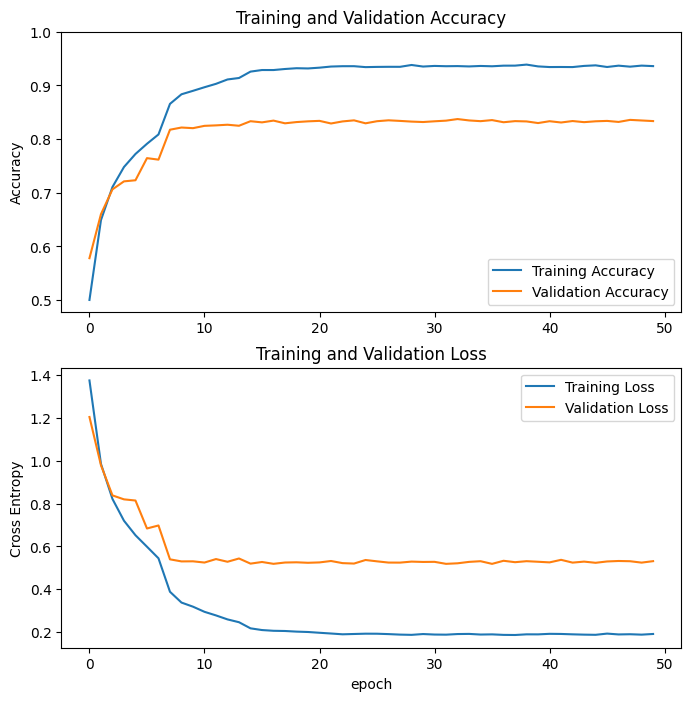

In [ ]:
train_acc = [t.cpu() for t in history['train_acc']]
val_acc = [t.cpu() for t in history['val_acc']]

plot_save_loss_acc(history['train_loss'] ,train_acc ,history['val_loss'] ,val_acc  , dir= model_fig_dir ,model_name = f'custom_vgg_11 model', save = False)


In [ ]:
preds_ , real_ , metrics_ = evaluate_model(model_base , test_dataloader ,device , False)

In [ ]:
accuracy_score(real_, preds_)

0.8473

### model layer analysis with center SI


#### utils

In [ ]:
def model_feature_extraction(model, X_data,layers_names):
    """
    extract intermediate outputs of model from all innermost layers for X_data.
    output is a dictionary with layers name as keys and outputs of model as values
    """
    # extract all layers features
    return_nodes = {leaf: leaf for leaf in layers_names}
    extraction_model = create_feature_extractor(model, return_nodes=return_nodes)
    intermediate_outputs = extraction_model(X_data)


    # flat extracted features of each layer
    n_data = X_data.shape[0]
    for leaf in layers_names:
        intermediate_outputs[leaf] = intermediate_outputs[leaf].reshape(n_data, -1).to(torch.float32)

    return intermediate_outputs

In [ ]:
def center_separation_index(data, label,device1):
    """
    Calculate Center-based Separation Index (CSI) for a given dataset.

    Parameters:
    - data (tensor): The input data points.
    - label (tensor): Labels associated with each data point.

    Returns:
    - csi (float): Center-based Separation Index value, indicating the separation of classes
                   based on the proximity of each data point to its class center.
    """


    label_min = round(torch.min(label).detach().item())
    label = (label - label_min).to(device1)
    data = data.to(device)

    n_class = round(torch.max(label).detach().item()) + 1
    n_data = int(data.shape[0])
    n_feature = int(data.shape[1])

    label_feature_class = torch.arange(n_class, device=device1).repeat([n_data, n_feature, 1])
    label_feature_matrix = label.reshape([-1, 1, 1]).repeat([1, n_feature, 1]).repeat([1, 1, n_class])

    label_comp = (label_feature_class == label_feature_matrix) * 1
    data_class = data.reshape([-1, n_feature, 1]).repeat([1, 1, n_class])
    data_class_center = ((data_class * label_comp).sum(0) / (label_comp).sum(0)).transpose(0, 1)
    dis_matrix = torch.cdist(data, data_class_center, p=2)
    values, label_neighb_center = torch.min(dis_matrix, 1)
    label_neighb_center = label_neighb_center.reshape([-1, 1])
    csi = torch.sum(label_neighb_center == label) / n_data


    return csi

def calc_center_si_score(intermediate_outputs, y_data, leaf_layers_names):
    layers_center_si_score = []
    for layer_name in tqdm(leaf_layers_names):
        center_si_score = center_separation_index(intermediate_outputs[layer_name], y_data, device)
        center_si_score = center_si_score.detach().cpu().numpy()
        layers_center_si_score.append(center_si_score)

    return layers_center_si_score

#### load a sample of data

In [ ]:
# load a batch of size 1000 from train and test to avoid lack of memory error
X_train, y_train, X_test, y_test = sample_from_CIFAR10(train_size=300, test_size=300)

X_train, y_train = X_train.to(device), y_train.to(device)


Files already downloaded and verified
Files already downloaded and verified


In [ ]:
X_test, y_test = X_test.to(device), y_test.to(device)

#### load the model

In [ ]:
# Specify the path to the file containing the best model parameters
best_model_params_path_resnet = os.path.join(f'{model_config_dir}/Custom_VGG_11/best_model_params.pt')

# Create an instance of model
model_vgg = load_pre_trained_model(best_model_params_path_resnet , device )

# Put the model in evaluation mode to fix parameters during feature extraction
model_vgg.eval()

Custom_VGG_11(
  (layers): Sequential(
    (layer0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (layer1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer2): ReLU()
    (layer3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (layer4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (layer5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer6): ReLU()
    (layer7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (layer8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (layer9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer10): ReLU()
    (layer11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (layer12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer13):

#### layers feature extraction

In [ ]:
leaf_layers_names =[]
for name, layer in model_vgg.named_modules():
    if isinstance(layer, torch.nn.MaxPool2d):
        print(name, layer)
        leaf_layers_names.append(name)
    elif isinstance(layer, torch.nn.Linear) or  isinstance(layer, torch.nn.Flatten):
        print(name, layer)
        leaf_layers_names.append(name)


layers.layer3 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
layers.layer7 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
layers.layer14 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
layers.layer21 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
layers.layer28 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
layers.layer29 Flatten(start_dim=1, end_dim=-1)
layers.layer30 Linear(in_features=512, out_features=512, bias=True)
layers.layer31 Linear(in_features=512, out_features=10, bias=True)


In [ ]:
print("Number of all leaf layers i.e., layers in the lowest level:", len(leaf_layers_names))

Number of all leaf layers i.e., layers in the lowest level: 7


In [ ]:
# extract features for train and test set
train_intermediate_outputs = model_feature_extraction(model_vgg, X_train , leaf_layers_names)
test_intermediate_outputs = model_feature_extraction(model_vgg, X_test ,leaf_layers_names )

In [ ]:
for i in train_intermediate_outputs.keys():
    print(train_intermediate_outputs[i].shape)

torch.Size([100, 16384])
torch.Size([100, 8192])
torch.Size([100, 4096])
torch.Size([100, 2048])
torch.Size([100, 512])
torch.Size([100, 512])
torch.Size([100, 512])
torch.Size([100, 10])


In [ ]:
# change type of labels to float to work well on SI calculations
y_train = y_train.to(torch.float32)
y_test = y_test.to(torch.float32)

#### Center SI

In [ ]:
!nvidia-smi

Sat Dec 30 07:25:07 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P0              29W /  70W |  14777MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
# calculate center si score of all intermediates layers outputs for train and test data
train_layer_center_si_scores = calc_center_si_score(train_intermediate_outputs, y_train, leaf_layers_names)


100%|██████████| 8/8 [00:00<00:00, 28.21it/s]


In [ ]:
test_layer_center_si_scores = calc_center_si_score(test_intermediate_outputs, y_test, leaf_layers_names)

100%|██████████| 8/8 [00:00<00:00, 27.76it/s]


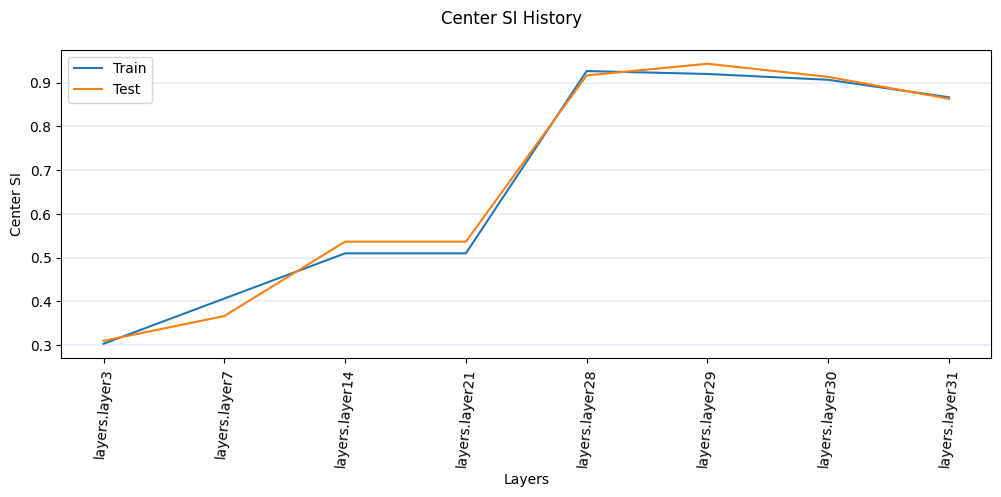

In [ ]:
# plot SI history for train and test
plt.figure(figsize=(12, 4))
plt.plot(leaf_layers_names, train_layer_center_si_scores, label='Train')
plt.plot(leaf_layers_names, test_layer_center_si_scores, label='Test')

plt.ylabel('Center SI')
plt.xlabel('Layers')
plt.xticks(rotation=85)
plt.suptitle('Center SI History')
plt.legend()
plt.grid(axis='y', color='b', linestyle='-', linewidth=0.1)
plt.show()

# Layer-wise training

## Hyper_parameters

In [ ]:
EPOCHS_LAYER =7
INIT_LR = 0.01
GAMMA = 0.1
STEP_SIZE = 3
WEIGHT_DECAY = 5e-4
MOMENTUM = 0.9

## utils

In [ ]:
def plot_layered_results(train_loss, train_acc, valid_loss, valid_acc, layer):
    if layer < 8:
        label_font = 6
        title_font = 10
        fig_size = (6, 3)
    else:
        label_font = 12
        title_font = 20
        fig_size = (10, 5)

    num_epochs = len(train_loss)
    epochs = np.linspace(1, num_epochs, num_epochs)

    fig = plt.figure(figsize=fig_size)
    (ax1, ax2) = fig.subplots(1, 2)

    loss_labels = ['train', 'valid']
    acc_labels = ['train', 'valid']

    ax1.plot(epochs, train_loss)
    ax1.plot(epochs, valid_loss)

    ax2.plot(epochs, np.array(train_acc))
    ax2.plot(epochs, np.array(valid_acc))

    ax1.set_xlabel('Epochs', fontsize=label_font)
    ax1.set_ylabel('Loss', fontsize=label_font)
    ax2.set_xlabel('Epochs', fontsize=label_font)
    ax2.set_ylabel('Accuracy (%)', fontsize=label_font)

    ax1.set_title(f"Loss for layer {layer} ", fontsize=title_font)
    ax2.set_title(f"Accuracy for layer {layer} ", fontsize=title_font)

    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)

    ax1.legend(loss_labels)
    ax2.legend(acc_labels)
    plt.show()

In [ ]:
class LayeredVGG11(nn.Module):

    def __init__(self):
        super(LayeredVGG11, self).__init__()

        self.num_classes = 10

        # Create layer structure
        layers = [
        ('layer'+str(0), nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)),
        ('layer'+str(1), nn.BatchNorm2d(64)),
        ('layer'+str(2), nn.ReLU()),
        ('layer'+str(3), nn.MaxPool2d(kernel_size=2, stride=2)),
        ('layer'+str(4), nn.Flatten())
        ]

        # Create output layers
        layers.append(('layer'+str(5), nn.Linear(64*16*16, 512)))
        layers.append(('layer'+str(6), nn.Linear(512, self.num_classes)))

        # Initialize the Sequential structure
        self.layers = nn.Sequential(OrderedDict(layers))



    def forward(self, x):
        '''Forward pass'''
        return self.layers(x)


    def set_structure(self, layers):
        self.layers = nn.Sequential(OrderedDict(layers))

In [ ]:
def add_new_layer(model, channels, mp=True, no_grad=True, conv=True):
    """ Add a new layer to a model, setting all others to nontrainable. """

    layers = model.layers
    new_structure = []

    for layer_index in range(len(layers) - 3):

        old_layer = layers[layer_index]
        if no_grad:
            for param in old_layer.parameters():
                param.requires_grad = False

        new_structure.append(('layer'+str(layer_index), old_layer))

    if conv:
        # Append new layer to the final intermediate layer
        new_layers = [
            ('layer'+str(len(new_structure)), nn.Conv2d(in_channels=channels[0], out_channels=channels[1], kernel_size=3, padding=1)),
            ('layer'+str(len(new_structure)+1), nn.BatchNorm2d(channels[1])),
            ('layer'+str(len(new_structure)+2), nn.ReLU())
            ]
        if mp:
            new_layers.append(('layer'+str(len(new_structure)+3), nn.MaxPool2d(kernel_size=2, stride=2)))
        new_structure += new_layers

    # classification layers
    new_structure.append(('layer'+str(len(new_structure)), nn.Flatten()))
    new_structure.append(('layer'+str(len(new_structure)), nn.Linear(channels[1]*channels[2]*channels[2], 512)))
    new_structure.append(('layer'+str(len(new_structure)), nn.Linear(512, 10)))

    model.set_structure(new_structure)

    return model

In [ ]:
def train_layered_model(model, model_name, no_grad=True, part_e = False,part_d = False):
    """
    desc: function to gradually add layers and train the model
    model: the model gradually adding layers to
    model_name: the name of the model to be saved
    no_grad: if the previous layers are frozen -> Set to True for part B
    change_trans: wether to change data augmentation -> Set to True for parts D and E
    """
    layered_histories = []
    layered_models = []

    # in and out channels of covolution layers and the multiplier of the dense layers
    channels = [[64 ,128,8], [128,256,8], [256,256,4], [256,512,4],
                [512,512,2], [512,512,2], [512,512,1]]
    # wether to use maxpooling in the adding layers
    maxpool = [True, False, True, False, True, False, True]

    # defining dataloader and dataset for train/test/val with defined batch size
    train_dataset , val_dataset , test_dataset = get_CIFAR10(reduce_trans = part_e) # for part E, first only color jitter is applied and the all other augmentations
    test_dataloader =  DataLoader(test_dataset, batch_size=BATCH_SIZE_TEST,shuffle=True)
    train_dataloader =  DataLoader(train_dataset, batch_size=BATCH_SIZE_TRAIN,shuffle=True)
    val_dataloader =  DataLoader(val_dataset, batch_size=BATCH_SIZE_VAL,shuffle=True)

    #defining the hyperparameters
    optimizer = optim.SGD(model.parameters(), lr=INIT_LR, momentum= MOMENTUM, weight_decay= WEIGHT_DECAY)
    LR_scheduler =  optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)
    criterion = nn.CrossEntropyLoss()
    early_stopper = EarlyStopper(patience=2, min_delta=0.1)


    # training the model
    model , history = train_model(model, criterion, optimizer, LR_scheduler,early_stopper,
                                        dataset_sizes = {'train' : len(train_dataset), 'val':len(val_dataset)},
                                        dataloaders = {'train' : train_dataloader, 'val': val_dataloader},
                                        dir = os.path.join(model_config_dir , model_name),
                                        device = device,
                                        num_epochs=EPOCHS_LAYER , trained_weights=False)
    #saving the results
    layered_histories.append(history)
    layered_models.append(model)


    for i, (channel, mp) in enumerate(zip(channels, maxpool)):

        # First conv layer
        if i != 7:
            model = add_new_layer(model, channel, mp, no_grad)
        # Last dense layers
        else:
            model = add_new_layer(model, channel, mp, no_grad, conv = False)

        model.to(device)

        # if dataset is to be modified
        if (part_e or part_d)  and i == 3:
            # for layers greater than 4, dataset is changed
            # for part D, first all augmentations are applied and then changed to only color jitter
            # for part E, first only color jitter is applied and the all other augmentations

            train_dataset , val_dataset , test_dataset = get_CIFAR10(reduce_trans = part_d)
            test_dataloader =  DataLoader(test_dataset, batch_size=BATCH_SIZE_TEST,shuffle=True)
            train_dataloader =  DataLoader(train_dataset, batch_size=BATCH_SIZE_TRAIN,shuffle=True)
            val_dataloader =  DataLoader(val_dataset, batch_size=BATCH_SIZE_VAL,shuffle=True)


        optimizer = optim.SGD(model.parameters(), lr=INIT_LR, momentum= MOMENTUM, weight_decay= WEIGHT_DECAY)
        LR_scheduler =  optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)


        # training the model
        model , history = train_model(model, criterion, optimizer, LR_scheduler,early_stopper,
                                            dataset_sizes = {'train' : len(train_dataset), 'val':len(val_dataset)},
                                            dataloaders = {'train' : train_dataloader, 'val': val_dataloader},
                                            dir = os.path.join(model_config_dir , f'{model_name}_layer{i}'),
                                            device = device,
                                            num_epochs=EPOCHS_LAYER , trained_weights=False)
        #saving the results
        layered_histories.append(history)
        layered_models.append(model)



    return model, layered_histories ,layered_models

In [ ]:
def load_pre_trained_model_layered(path , device):

  # Create an instance of model
  model = LayeredVGG11()

  # Load the best model parameters into the model
  model.load_state_dict(torch.load(path, map_location=device))

  # Move the model to the specified device (e.g., GPU)
  model = model.to(device)


  return model

## B

### train

In [ ]:
model = LayeredVGG11()
model.to(device)
model_name = 'layered_B'
model, layered_histories,layered_models = train_layered_model(model, model_name, no_grad=True,part_e = False,part_d = False)

Files already downloaded and verified
Files already downloaded and verified
Epoch 0/6
--------------------


100%|██████████| 293/293 [00:35<00:00,  8.25it/s]


train Loss: 2.3387 Acc: 0.3510 LR: 0.01


100%|██████████| 98/98 [00:10<00:00,  9.57it/s]


val Loss: 1.5970 Acc: 0.4359 LR: 0.01
Saving best model with acc:  tensor(0.4359, device='cuda:0', dtype=torch.float64)

Epoch 1/6
--------------------


100%|██████████| 293/293 [00:35<00:00,  8.19it/s]


train Loss: 1.4640 Acc: 0.4800 LR: 0.01


100%|██████████| 98/98 [00:10<00:00,  9.06it/s]


val Loss: 1.3834 Acc: 0.5160 LR: 0.01
Saving best model with acc:  tensor(0.5160, device='cuda:0', dtype=torch.float64)

Epoch 2/6
--------------------


100%|██████████| 293/293 [00:33<00:00,  8.78it/s]


train Loss: 1.3578 Acc: 0.5189 LR: 0.01


100%|██████████| 98/98 [00:10<00:00,  9.04it/s]


val Loss: 1.3478 Acc: 0.5314 LR: 0.001
Saving best model with acc:  tensor(0.5314, device='cuda:0', dtype=torch.float64)

Epoch 3/6
--------------------


100%|██████████| 293/293 [00:33<00:00,  8.75it/s]


train Loss: 1.2523 Acc: 0.5662 LR: 0.001


100%|██████████| 98/98 [00:11<00:00,  8.90it/s]


val Loss: 1.2726 Acc: 0.5562 LR: 0.001
Saving best model with acc:  tensor(0.5562, device='cuda:0', dtype=torch.float64)

Epoch 4/6
--------------------


100%|██████████| 293/293 [00:33<00:00,  8.74it/s]


train Loss: 1.2313 Acc: 0.5697 LR: 0.001


100%|██████████| 98/98 [00:10<00:00,  9.02it/s]


val Loss: 1.2606 Acc: 0.5638 LR: 0.001
Saving best model with acc:  tensor(0.5638, device='cuda:0', dtype=torch.float64)

Epoch 5/6
--------------------


100%|██████████| 293/293 [00:33<00:00,  8.76it/s]


train Loss: 1.2160 Acc: 0.5791 LR: 0.001


100%|██████████| 98/98 [00:11<00:00,  8.20it/s]


val Loss: 1.2503 Acc: 0.5625 LR: 0.0001

Epoch 6/6
--------------------


100%|██████████| 293/293 [00:34<00:00,  8.41it/s]


train Loss: 1.1990 Acc: 0.5847 LR: 0.0001


100%|██████████| 98/98 [00:11<00:00,  8.90it/s]


val Loss: 1.2390 Acc: 0.5670 LR: 0.0001
Saving best model with acc:  tensor(0.5670, device='cuda:0', dtype=torch.float64)

Training complete in 5m 18s
Best val Acc: 0.566960
Epoch 0/6
--------------------


100%|██████████| 293/293 [00:33<00:00,  8.88it/s]


train Loss: 1.4030 Acc: 0.4953 LR: 0.01


100%|██████████| 98/98 [00:10<00:00,  8.93it/s]


val Loss: 1.2372 Acc: 0.5618 LR: 0.01
Saving best model with acc:  tensor(0.5618, device='cuda:0', dtype=torch.float64)

Epoch 1/6
--------------------


100%|██████████| 293/293 [00:32<00:00,  8.88it/s]


train Loss: 1.1747 Acc: 0.5804 LR: 0.01


100%|██████████| 98/98 [00:10<00:00,  8.96it/s]


val Loss: 1.1671 Acc: 0.5858 LR: 0.01
Saving best model with acc:  tensor(0.5858, device='cuda:0', dtype=torch.float64)

Epoch 2/6
--------------------


100%|██████████| 293/293 [00:33<00:00,  8.87it/s]


train Loss: 1.0984 Acc: 0.6103 LR: 0.01


100%|██████████| 98/98 [00:10<00:00,  8.99it/s]


val Loss: 1.1510 Acc: 0.5902 LR: 0.001
Saving best model with acc:  tensor(0.5902, device='cuda:0', dtype=torch.float64)

Epoch 3/6
--------------------


100%|██████████| 293/293 [00:33<00:00,  8.75it/s]


train Loss: 0.9678 Acc: 0.6600 LR: 0.001


100%|██████████| 98/98 [00:11<00:00,  8.88it/s]


val Loss: 0.9939 Acc: 0.6488 LR: 0.001
Saving best model with acc:  tensor(0.6488, device='cuda:0', dtype=torch.float64)

Epoch 4/6
--------------------


100%|██████████| 293/293 [00:33<00:00,  8.84it/s]


train Loss: 0.9356 Acc: 0.6717 LR: 0.001


100%|██████████| 98/98 [00:10<00:00,  9.11it/s]


val Loss: 0.9815 Acc: 0.6586 LR: 0.001
Saving best model with acc:  tensor(0.6586, device='cuda:0', dtype=torch.float64)

Epoch 5/6
--------------------


100%|██████████| 293/293 [00:33<00:00,  8.84it/s]


train Loss: 0.9255 Acc: 0.6774 LR: 0.001


100%|██████████| 98/98 [00:10<00:00,  9.37it/s]


val Loss: 0.9731 Acc: 0.6646 LR: 0.0001
Saving best model with acc:  tensor(0.6646, device='cuda:0', dtype=torch.float64)

Epoch 6/6
--------------------


100%|██████████| 293/293 [00:33<00:00,  8.82it/s]


train Loss: 0.9064 Acc: 0.6845 LR: 0.0001


100%|██████████| 98/98 [00:10<00:00,  9.59it/s]


val Loss: 0.9600 Acc: 0.6661 LR: 0.0001
Saving best model with acc:  tensor(0.6661, device='cuda:0', dtype=torch.float64)

Training complete in 5m 8s
Best val Acc: 0.666080
Epoch 0/6
--------------------


100%|██████████| 293/293 [00:34<00:00,  8.56it/s]


train Loss: 1.1598 Acc: 0.5878 LR: 0.01


100%|██████████| 98/98 [00:10<00:00,  9.13it/s]


val Loss: 0.9898 Acc: 0.6508 LR: 0.01
Saving best model with acc:  tensor(0.6508, device='cuda:0', dtype=torch.float64)

Epoch 1/6
--------------------


100%|██████████| 293/293 [00:33<00:00,  8.67it/s]


train Loss: 0.9546 Acc: 0.6626 LR: 0.01


100%|██████████| 98/98 [00:10<00:00,  9.32it/s]


val Loss: 0.9434 Acc: 0.6683 LR: 0.01
Saving best model with acc:  tensor(0.6683, device='cuda:0', dtype=torch.float64)

Epoch 2/6
--------------------


100%|██████████| 293/293 [00:33<00:00,  8.71it/s]


train Loss: 0.8866 Acc: 0.6857 LR: 0.01


100%|██████████| 98/98 [00:10<00:00,  9.09it/s]


val Loss: 0.8933 Acc: 0.6846 LR: 0.001
Saving best model with acc:  tensor(0.6846, device='cuda:0', dtype=torch.float64)

Epoch 3/6
--------------------


100%|██████████| 293/293 [00:33<00:00,  8.74it/s]


train Loss: 0.7447 Acc: 0.7400 LR: 0.001


100%|██████████| 98/98 [00:11<00:00,  8.88it/s]


val Loss: 0.8043 Acc: 0.7192 LR: 0.001
Saving best model with acc:  tensor(0.7192, device='cuda:0', dtype=torch.float64)

Epoch 4/6
--------------------


100%|██████████| 293/293 [00:33<00:00,  8.80it/s]


train Loss: 0.7162 Acc: 0.7478 LR: 0.001


100%|██████████| 98/98 [00:11<00:00,  8.85it/s]


val Loss: 0.8007 Acc: 0.7227 LR: 0.001
Saving best model with acc:  tensor(0.7227, device='cuda:0', dtype=torch.float64)

Epoch 5/6
--------------------


100%|██████████| 293/293 [00:33<00:00,  8.81it/s]


train Loss: 0.6999 Acc: 0.7561 LR: 0.001


100%|██████████| 98/98 [00:11<00:00,  8.87it/s]


val Loss: 0.7871 Acc: 0.7253 LR: 0.0001
Saving best model with acc:  tensor(0.7253, device='cuda:0', dtype=torch.float64)

Epoch 6/6
--------------------


100%|██████████| 293/293 [00:33<00:00,  8.73it/s]


train Loss: 0.6796 Acc: 0.7629 LR: 0.0001


100%|██████████| 98/98 [00:11<00:00,  8.77it/s]


val Loss: 0.7736 Acc: 0.7334 LR: 0.0001
Saving best model with acc:  tensor(0.7334, device='cuda:0', dtype=torch.float64)

Training complete in 5m 13s
Best val Acc: 0.733360
Epoch 0/6
--------------------


100%|██████████| 293/293 [00:33<00:00,  8.79it/s]


train Loss: 0.9975 Acc: 0.6474 LR: 0.01


100%|██████████| 98/98 [00:11<00:00,  8.84it/s]


val Loss: 0.8576 Acc: 0.7040 LR: 0.01
Saving best model with acc:  tensor(0.7040, device='cuda:0', dtype=torch.float64)

Epoch 1/6
--------------------


100%|██████████| 293/293 [00:33<00:00,  8.70it/s]


train Loss: 0.8080 Acc: 0.7155 LR: 0.01


100%|██████████| 98/98 [00:11<00:00,  8.81it/s]


val Loss: 0.8615 Acc: 0.7032 LR: 0.01

Epoch 2/6
--------------------


100%|██████████| 293/293 [00:33<00:00,  8.83it/s]


train Loss: 0.7492 Acc: 0.7363 LR: 0.01


100%|██████████| 98/98 [00:11<00:00,  8.76it/s]


val Loss: 0.8091 Acc: 0.7166 LR: 0.001
Saving best model with acc:  tensor(0.7166, device='cuda:0', dtype=torch.float64)

Epoch 3/6
--------------------


100%|██████████| 293/293 [00:33<00:00,  8.66it/s]


train Loss: 0.6401 Acc: 0.7760 LR: 0.001


100%|██████████| 98/98 [00:11<00:00,  8.69it/s]


val Loss: 0.7359 Acc: 0.7430 LR: 0.001
Saving best model with acc:  tensor(0.7430, device='cuda:0', dtype=torch.float64)

Epoch 4/6
--------------------


100%|██████████| 293/293 [00:35<00:00,  8.22it/s]


train Loss: 0.6159 Acc: 0.7846 LR: 0.001


100%|██████████| 98/98 [00:11<00:00,  8.86it/s]


val Loss: 0.7256 Acc: 0.7457 LR: 0.001
Saving best model with acc:  tensor(0.7457, device='cuda:0', dtype=torch.float64)

Epoch 5/6
--------------------


100%|██████████| 293/293 [00:33<00:00,  8.87it/s]


train Loss: 0.6050 Acc: 0.7890 LR: 0.001


100%|██████████| 98/98 [00:11<00:00,  8.72it/s]


val Loss: 0.7098 Acc: 0.7538 LR: 0.0001
Saving best model with acc:  tensor(0.7538, device='cuda:0', dtype=torch.float64)

Epoch 6/6
--------------------


100%|██████████| 293/293 [00:33<00:00,  8.71it/s]


train Loss: 0.5886 Acc: 0.7955 LR: 0.0001


100%|██████████| 98/98 [00:11<00:00,  8.71it/s]


val Loss: 0.7120 Acc: 0.7516 LR: 0.0001

Training complete in 5m 15s
Best val Acc: 0.753760
Epoch 0/6
--------------------


100%|██████████| 293/293 [00:33<00:00,  8.66it/s]


train Loss: 0.8058 Acc: 0.7178 LR: 0.01


100%|██████████| 98/98 [00:11<00:00,  8.69it/s]


val Loss: 0.8047 Acc: 0.7266 LR: 0.01
Saving best model with acc:  tensor(0.7266, device='cuda:0', dtype=torch.float64)

Epoch 1/6
--------------------


100%|██████████| 293/293 [00:33<00:00,  8.73it/s]


train Loss: 0.6736 Acc: 0.7627 LR: 0.01


100%|██████████| 98/98 [00:11<00:00,  8.60it/s]


val Loss: 0.7747 Acc: 0.7400 LR: 0.01
Saving best model with acc:  tensor(0.7400, device='cuda:0', dtype=torch.float64)

Epoch 2/6
--------------------


100%|██████████| 293/293 [00:33<00:00,  8.74it/s]


train Loss: 0.6326 Acc: 0.7772 LR: 0.01


100%|██████████| 98/98 [00:11<00:00,  8.68it/s]


val Loss: 0.8138 Acc: 0.7270 LR: 0.001

Epoch 3/6
--------------------


100%|██████████| 293/293 [00:33<00:00,  8.63it/s]


train Loss: 0.5448 Acc: 0.8087 LR: 0.001


100%|██████████| 98/98 [00:11<00:00,  8.48it/s]


val Loss: 0.6909 Acc: 0.7605 LR: 0.001
Saving best model with acc:  tensor(0.7605, device='cuda:0', dtype=torch.float64)

Epoch 4/6
--------------------


100%|██████████| 293/293 [00:33<00:00,  8.65it/s]


train Loss: 0.5241 Acc: 0.8153 LR: 0.001


100%|██████████| 98/98 [00:11<00:00,  8.64it/s]


val Loss: 0.6968 Acc: 0.7571 LR: 0.001

Epoch 5/6
--------------------


100%|██████████| 293/293 [00:34<00:00,  8.58it/s]


train Loss: 0.5143 Acc: 0.8201 LR: 0.001


100%|██████████| 98/98 [00:11<00:00,  8.80it/s]


val Loss: 0.6831 Acc: 0.7671 LR: 0.0001
Saving best model with acc:  tensor(0.7671, device='cuda:0', dtype=torch.float64)

Epoch 6/6
--------------------


100%|██████████| 293/293 [00:34<00:00,  8.51it/s]


train Loss: 0.5005 Acc: 0.8227 LR: 0.0001


100%|██████████| 98/98 [00:10<00:00,  9.06it/s]


val Loss: 0.6731 Acc: 0.7667 LR: 0.0001

Training complete in 5m 17s
Best val Acc: 0.767120
Epoch 0/6
--------------------


100%|██████████| 293/293 [00:35<00:00,  8.15it/s]


train Loss: 0.7062 Acc: 0.7522 LR: 0.01


100%|██████████| 98/98 [00:10<00:00,  9.61it/s]


val Loss: 0.7726 Acc: 0.7385 LR: 0.01
Saving best model with acc:  tensor(0.7385, device='cuda:0', dtype=torch.float64)

Epoch 1/6
--------------------


100%|██████████| 293/293 [00:35<00:00,  8.24it/s]


train Loss: 0.5872 Acc: 0.7917 LR: 0.01


100%|██████████| 98/98 [00:10<00:00,  8.92it/s]


val Loss: 0.7385 Acc: 0.7546 LR: 0.01
Saving best model with acc:  tensor(0.7546, device='cuda:0', dtype=torch.float64)

Epoch 2/6
--------------------


100%|██████████| 293/293 [00:35<00:00,  8.37it/s]


train Loss: 0.5514 Acc: 0.8078 LR: 0.01


100%|██████████| 98/98 [00:11<00:00,  8.53it/s]


val Loss: 0.7315 Acc: 0.7542 LR: 0.001

Epoch 3/6
--------------------


100%|██████████| 293/293 [00:34<00:00,  8.49it/s]


train Loss: 0.4822 Acc: 0.8293 LR: 0.001


100%|██████████| 98/98 [00:11<00:00,  8.35it/s]


val Loss: 0.6815 Acc: 0.7703 LR: 0.001
Saving best model with acc:  tensor(0.7703, device='cuda:0', dtype=torch.float64)

Epoch 4/6
--------------------


100%|██████████| 293/293 [00:34<00:00,  8.53it/s]


train Loss: 0.4726 Acc: 0.8335 LR: 0.001


100%|██████████| 98/98 [00:11<00:00,  8.71it/s]


val Loss: 0.6851 Acc: 0.7678 LR: 0.001

Epoch 5/6
--------------------


100%|██████████| 293/293 [00:34<00:00,  8.54it/s]


train Loss: 0.4587 Acc: 0.8382 LR: 0.001


100%|██████████| 98/98 [00:11<00:00,  8.40it/s]


val Loss: 0.6757 Acc: 0.7701 LR: 0.0001

Epoch 6/6
--------------------


100%|██████████| 293/293 [00:34<00:00,  8.49it/s]


train Loss: 0.4531 Acc: 0.8402 LR: 0.0001


100%|██████████| 98/98 [00:11<00:00,  8.65it/s]


val Loss: 0.6757 Acc: 0.7731 LR: 0.0001
Saving best model with acc:  tensor(0.7731, device='cuda:0', dtype=torch.float64)

Training complete in 5m 23s
Best val Acc: 0.773120
Epoch 0/6
--------------------


100%|██████████| 293/293 [00:36<00:00,  8.09it/s]


train Loss: 0.5759 Acc: 0.8029 LR: 0.01


100%|██████████| 98/98 [00:10<00:00,  9.18it/s]


val Loss: 0.7087 Acc: 0.7620 LR: 0.01
Saving best model with acc:  tensor(0.7620, device='cuda:0', dtype=torch.float64)

Epoch 1/6
--------------------


100%|██████████| 293/293 [00:35<00:00,  8.17it/s]


train Loss: 0.5019 Acc: 0.8233 LR: 0.01


100%|██████████| 98/98 [00:11<00:00,  8.70it/s]


val Loss: 0.7104 Acc: 0.7627 LR: 0.01
Saving best model with acc:  tensor(0.7627, device='cuda:0', dtype=torch.float64)

Epoch 2/6
--------------------


100%|██████████| 293/293 [00:37<00:00,  7.79it/s]


train Loss: 0.4794 Acc: 0.8325 LR: 0.01


100%|██████████| 98/98 [00:11<00:00,  8.51it/s]


val Loss: 0.7260 Acc: 0.7599 LR: 0.001

Epoch 3/6
--------------------


100%|██████████| 293/293 [00:34<00:00,  8.37it/s]


train Loss: 0.4514 Acc: 0.8403 LR: 0.001


100%|██████████| 98/98 [00:11<00:00,  8.29it/s]


val Loss: 0.6869 Acc: 0.7708 LR: 0.001
Saving best model with acc:  tensor(0.7708, device='cuda:0', dtype=torch.float64)

Epoch 4/6
--------------------


100%|██████████| 293/293 [00:34<00:00,  8.43it/s]


train Loss: 0.4465 Acc: 0.8421 LR: 0.001


100%|██████████| 98/98 [00:11<00:00,  8.35it/s]


val Loss: 0.6810 Acc: 0.7674 LR: 0.001

Epoch 5/6
--------------------


100%|██████████| 293/293 [00:34<00:00,  8.38it/s]


train Loss: 0.4407 Acc: 0.8448 LR: 0.001


100%|██████████| 98/98 [00:11<00:00,  8.56it/s]


val Loss: 0.6775 Acc: 0.7757 LR: 0.0001
Saving best model with acc:  tensor(0.7757, device='cuda:0', dtype=torch.float64)

Epoch 6/6
--------------------


100%|██████████| 293/293 [00:35<00:00,  8.15it/s]


train Loss: 0.4350 Acc: 0.8456 LR: 0.0001


100%|██████████| 98/98 [00:10<00:00,  9.21it/s]


val Loss: 0.6787 Acc: 0.7727 LR: 0.0001

Training complete in 5m 30s
Best val Acc: 0.775680
Epoch 0/6
--------------------


100%|██████████| 293/293 [00:36<00:00,  7.93it/s]


train Loss: 0.5185 Acc: 0.8224 LR: 0.01


100%|██████████| 98/98 [00:11<00:00,  8.36it/s]


val Loss: 0.7044 Acc: 0.7685 LR: 0.01
Saving best model with acc:  tensor(0.7685, device='cuda:0', dtype=torch.float64)

Epoch 1/6
--------------------


100%|██████████| 293/293 [00:35<00:00,  8.24it/s]


train Loss: 0.4676 Acc: 0.8356 LR: 0.01


100%|██████████| 98/98 [00:11<00:00,  8.17it/s]


val Loss: 0.7110 Acc: 0.7646 LR: 0.01

Epoch 2/6
--------------------


100%|██████████| 293/293 [00:35<00:00,  8.23it/s]


train Loss: 0.4655 Acc: 0.8359 LR: 0.01


100%|██████████| 98/98 [00:12<00:00,  7.99it/s]


val Loss: 0.7060 Acc: 0.7683 LR: 0.001

Epoch 3/6
--------------------


100%|██████████| 293/293 [00:36<00:00,  8.12it/s]


train Loss: 0.4430 Acc: 0.8446 LR: 0.001


100%|██████████| 98/98 [00:11<00:00,  8.77it/s]


val Loss: 0.6869 Acc: 0.7711 LR: 0.001
Saving best model with acc:  tensor(0.7711, device='cuda:0', dtype=torch.float64)

Epoch 4/6
--------------------


100%|██████████| 293/293 [00:36<00:00,  8.03it/s]


train Loss: 0.4355 Acc: 0.8463 LR: 0.001


100%|██████████| 98/98 [00:11<00:00,  8.59it/s]


val Loss: 0.6903 Acc: 0.7682 LR: 0.001

Epoch 5/6
--------------------


100%|██████████| 293/293 [00:36<00:00,  8.14it/s]


train Loss: 0.4379 Acc: 0.8456 LR: 0.001


100%|██████████| 98/98 [00:12<00:00,  7.94it/s]


val Loss: 0.6736 Acc: 0.7759 LR: 0.0001
Saving best model with acc:  tensor(0.7759, device='cuda:0', dtype=torch.float64)

Epoch 6/6
--------------------


100%|██████████| 293/293 [00:35<00:00,  8.21it/s]


train Loss: 0.4342 Acc: 0.8455 LR: 0.0001


100%|██████████| 98/98 [00:11<00:00,  8.17it/s]


val Loss: 0.6897 Acc: 0.7714 LR: 0.0001

Training complete in 5m 36s
Best val Acc: 0.775920


### evaluate

In [ ]:
train_losses =[]
train_accs =[]
valid_losses =[]
valid_accs =[]

for history in layered_histories:
  train_acc = [t.cpu() for t in history['train_acc']]
  val_acc = [t.cpu() for t in history['val_acc']]

  train_losses.append(history['train_loss'])
  train_accs.append(train_acc)
  valid_losses.append(history['val_loss'])
  valid_accs.append(val_acc)



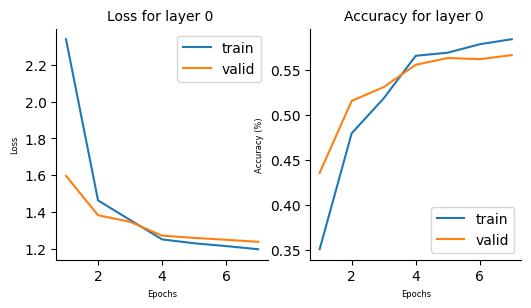

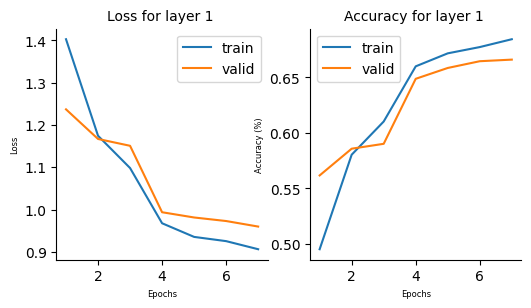

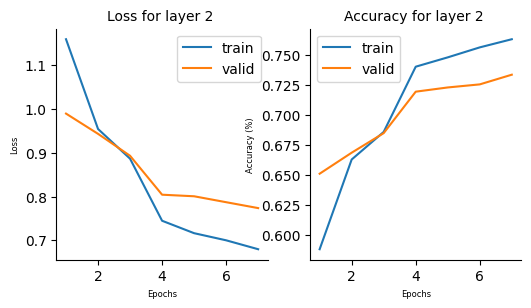

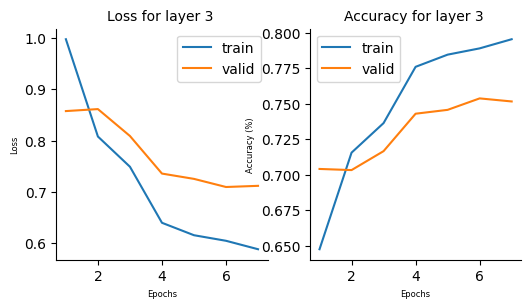

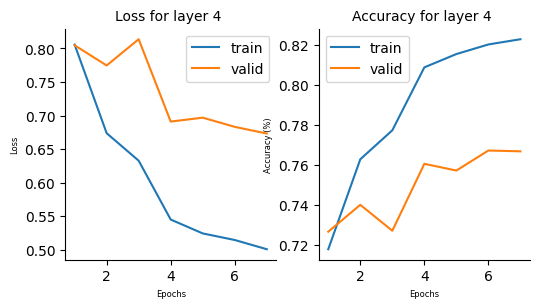

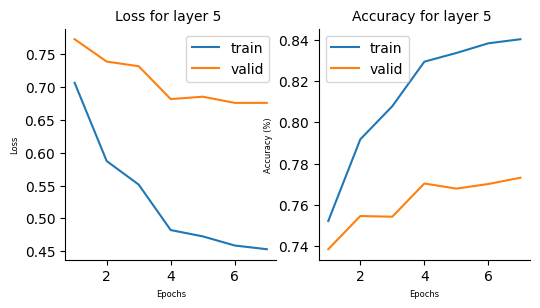

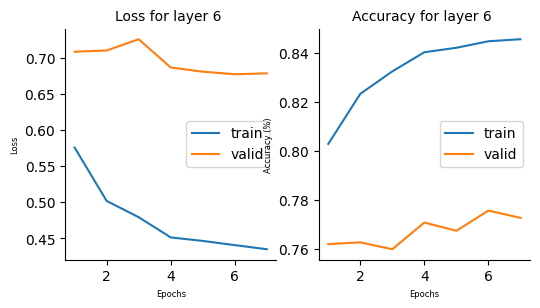

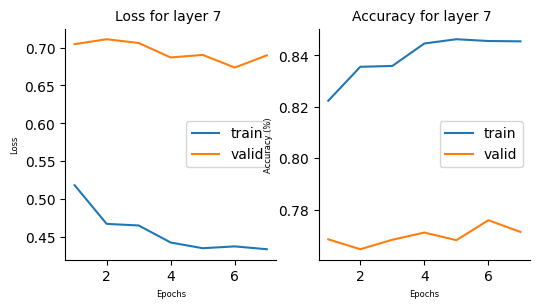

In [ ]:
for i in range(len(train_losses)):
  plot_layered_results(train_losses[i],train_accs[i], valid_losses[i], valid_accs[i], i)

In [ ]:
model_name = f'layered_B_layer6'
model_layered = load_pre_trained_model(os.path.join(f'{model_config_dir}/{model_name}/best_model_params.pt') , device )
model_layered.eval()
preds_ , real_ , metrics_ = evaluate_model(model_layered , test_dataloader ,device , False)
print(f'accuracy for layer: {accuracy_score(real_, preds_)}')


accuracy for layer: 0.7928


### CSI

#### load a sample of data

In [ ]:
# load a batch of size 1000 from train and test to avoid lack of memory error
X_train, y_train, X_test, y_test = sample_from_CIFAR10(train_size=300, test_size=300)

#### load the model

In [ ]:
!nvidia-smi

Sat Dec 30 07:54:00 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   76C    P0              30W /  70W |    767MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
model_name = f'layered_B_layer6'
model_layered = load_pre_trained_model(os.path.join(f'{model_config_dir}/{model_name}/best_model_params.pt') , device )
model_layered.eval()

Custom_VGG_11(
  (layers): Sequential(
    (layer0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (layer1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer2): ReLU()
    (layer3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (layer4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (layer5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer6): ReLU()
    (layer7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (layer8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (layer9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer10): ReLU()
    (layer11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (layer12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer13):

#### layers feature extraction

In [ ]:
leaf_layers_names =[]
for name, layer in model_layered.named_modules():
    if isinstance(layer, torch.nn.MaxPool2d):
        print(name, layer)
        leaf_layers_names.append(name)
    elif isinstance(layer, torch.nn.Linear) or  isinstance(layer, torch.nn.Flatten):
        print(name, layer)
        leaf_layers_names.append(name)

layers.layer3 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
layers.layer7 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
layers.layer14 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
layers.layer21 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
layers.layer28 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
layers.layer29 Flatten(start_dim=1, end_dim=-1)
layers.layer30 Linear(in_features=512, out_features=512, bias=True)
layers.layer31 Linear(in_features=512, out_features=10, bias=True)


In [ ]:
# extract features for train and test set
X_train, y_train = X_train.to(device), y_train.to(device)
train_intermediate_outputs = model_feature_extraction(model_layered, X_train,leaf_layers_names)
y_train = y_train.to(torch.float32)


In [ ]:
#free up memory and cache
del X_train , y_train , train_intermediate_outputs
torch.cuda.empty_cache()

In [ ]:
X_test, y_test = X_test.to(device), y_test.to(device)
test_intermediate_outputs = model_feature_extraction(model_layered, X_test,leaf_layers_names)
y_test = y_test.to(torch.float32)


In [ ]:
#free up memory and cache
del X_test , y_test , test_intermediate_outputs
torch.cuda.empty_cache()

#### Center SI

In [ ]:
# calculate center si score of all intermediates layers outputs for train and test data
train_layer_si_scores = calc_center_si_score(train_intermediate_outputs, y_train, leaf_layers_names)


100%|██████████| 8/8 [00:00<00:00, 20.07it/s]


In [ ]:
test_layer_si_scores = calc_center_si_score(test_intermediate_outputs, y_test, leaf_layers_names)

100%|██████████| 8/8 [00:00<00:00, 28.18it/s]


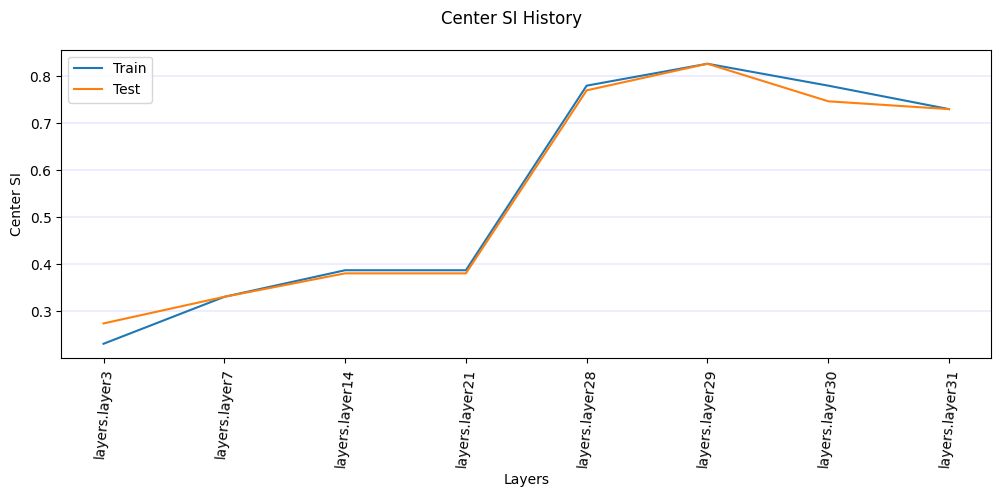

In [ ]:
# plot SI history for train and test
plt.figure(figsize=(12, 4))
plt.plot(leaf_layers_names, train_layer_si_scores, label='Train')
plt.plot(leaf_layers_names, test_layer_si_scores, label='Test')

plt.ylabel('Center SI')
plt.xlabel('Layers')
plt.xticks(rotation=85)
plt.suptitle('Center SI History')
plt.legend()
plt.grid(axis='y', color='b', linestyle='-', linewidth=0.1)
plt.show()

## C

### train

In [ ]:
model = LayeredVGG11()
model.to(device)
model_name = 'layered_C'
model, layered_histories,layered_models = train_layered_model(model, model_name, no_grad=False , part_e = False,part_d = False)

Files already downloaded and verified
Files already downloaded and verified
Epoch 0/7
--------------------


100%|██████████| 293/293 [00:35<00:00,  8.20it/s]


train Loss: 1.7165 Acc: 0.3998 LR: 0.01


100%|██████████| 98/98 [00:09<00:00, 10.85it/s]


val Loss: 1.4524 Acc: 0.4767 LR: 0.01
Saving best model with acc:  tensor(0.4767, device='cuda:0', dtype=torch.float64)

Epoch 1/7
--------------------


100%|██████████| 293/293 [00:33<00:00,  8.77it/s]


train Loss: 1.4470 Acc: 0.4864 LR: 0.01


100%|██████████| 98/98 [00:09<00:00, 10.13it/s]


val Loss: 1.3745 Acc: 0.5164 LR: 0.01
Saving best model with acc:  tensor(0.5164, device='cuda:0', dtype=torch.float64)

Epoch 2/7
--------------------


100%|██████████| 293/293 [00:34<00:00,  8.52it/s]


train Loss: 1.3477 Acc: 0.5238 LR: 0.01


100%|██████████| 98/98 [00:09<00:00, 10.11it/s]


val Loss: 1.3371 Acc: 0.5321 LR: 0.001
Saving best model with acc:  tensor(0.5321, device='cuda:0', dtype=torch.float64)

Epoch 3/7
--------------------


100%|██████████| 293/293 [00:32<00:00,  8.99it/s]


train Loss: 1.1929 Acc: 0.5858 LR: 0.001


100%|██████████| 98/98 [00:10<00:00,  9.62it/s]


val Loss: 1.1760 Acc: 0.5923 LR: 0.001
Saving best model with acc:  tensor(0.5923, device='cuda:0', dtype=torch.float64)

Epoch 4/7
--------------------


100%|██████████| 293/293 [00:32<00:00,  9.01it/s]


train Loss: 1.1629 Acc: 0.5951 LR: 0.001


100%|██████████| 98/98 [00:10<00:00,  9.02it/s]


val Loss: 1.1651 Acc: 0.5924 LR: 0.001
Saving best model with acc:  tensor(0.5924, device='cuda:0', dtype=torch.float64)

Epoch 5/7
--------------------


100%|██████████| 293/293 [00:32<00:00,  9.05it/s]


train Loss: 1.1466 Acc: 0.6026 LR: 0.001


100%|██████████| 98/98 [00:10<00:00,  9.25it/s]


val Loss: 1.1618 Acc: 0.5953 LR: 0.0001
Saving best model with acc:  tensor(0.5953, device='cuda:0', dtype=torch.float64)

Epoch 6/7
--------------------


100%|██████████| 293/293 [00:32<00:00,  9.10it/s]


train Loss: 1.1238 Acc: 0.6093 LR: 0.0001


100%|██████████| 98/98 [00:10<00:00,  9.37it/s]


val Loss: 1.1344 Acc: 0.6082 LR: 0.0001
Saving best model with acc:  tensor(0.6082, device='cuda:0', dtype=torch.float64)

Epoch 7/7
--------------------


100%|██████████| 293/293 [00:32<00:00,  9.09it/s]


train Loss: 1.1224 Acc: 0.6103 LR: 0.0001


100%|██████████| 98/98 [00:10<00:00,  9.34it/s]


val Loss: 1.1368 Acc: 0.6073 LR: 0.0001

Training complete in 5m 47s
Best val Acc: 0.608240
Epoch 0/7
--------------------


100%|██████████| 293/293 [00:32<00:00,  8.90it/s]


train Loss: 1.3890 Acc: 0.5038 LR: 0.01


100%|██████████| 98/98 [00:10<00:00,  9.24it/s]


val Loss: 1.2449 Acc: 0.5491 LR: 0.01
Saving best model with acc:  tensor(0.5491, device='cuda:0', dtype=torch.float64)

Epoch 1/7
--------------------


100%|██████████| 293/293 [00:33<00:00,  8.80it/s]


train Loss: 1.1372 Acc: 0.5966 LR: 0.01


100%|██████████| 98/98 [00:10<00:00,  9.11it/s]


val Loss: 1.2178 Acc: 0.5790 LR: 0.01
Saving best model with acc:  tensor(0.5790, device='cuda:0', dtype=torch.float64)

Epoch 2/7
--------------------


100%|██████████| 293/293 [00:33<00:00,  8.80it/s]


train Loss: 1.0503 Acc: 0.6311 LR: 0.01


100%|██████████| 98/98 [00:10<00:00,  9.17it/s]


val Loss: 1.0878 Acc: 0.6238 LR: 0.001
Saving best model with acc:  tensor(0.6238, device='cuda:0', dtype=torch.float64)

Epoch 3/7
--------------------


100%|██████████| 293/293 [00:33<00:00,  8.82it/s]


train Loss: 0.8912 Acc: 0.6912 LR: 0.001


100%|██████████| 98/98 [00:10<00:00,  9.05it/s]


val Loss: 0.8857 Acc: 0.6886 LR: 0.001
Saving best model with acc:  tensor(0.6886, device='cuda:0', dtype=torch.float64)

Epoch 4/7
--------------------


100%|██████████| 293/293 [00:33<00:00,  8.82it/s]


train Loss: 0.8616 Acc: 0.7010 LR: 0.001


100%|██████████| 98/98 [00:10<00:00,  9.20it/s]


val Loss: 0.8716 Acc: 0.6950 LR: 0.001
Saving best model with acc:  tensor(0.6950, device='cuda:0', dtype=torch.float64)

Epoch 5/7
--------------------


100%|██████████| 293/293 [00:33<00:00,  8.76it/s]


train Loss: 0.8446 Acc: 0.7092 LR: 0.001


100%|██████████| 98/98 [00:10<00:00,  9.22it/s]


val Loss: 0.8587 Acc: 0.7006 LR: 0.0001
Saving best model with acc:  tensor(0.7006, device='cuda:0', dtype=torch.float64)

Epoch 6/7
--------------------


100%|██████████| 293/293 [00:33<00:00,  8.79it/s]


train Loss: 0.8250 Acc: 0.7138 LR: 0.0001


100%|██████████| 98/98 [00:10<00:00,  9.04it/s]


val Loss: 0.8528 Acc: 0.7002 LR: 0.0001

Epoch 7/7
--------------------


100%|██████████| 293/293 [00:32<00:00,  8.96it/s]


train Loss: 0.8194 Acc: 0.7190 LR: 0.0001


100%|██████████| 98/98 [00:10<00:00,  9.23it/s]


val Loss: 0.8468 Acc: 0.7070 LR: 0.0001
Saving best model with acc:  tensor(0.7070, device='cuda:0', dtype=torch.float64)

Training complete in 5m 52s
Best val Acc: 0.707040
Epoch 0/7
--------------------


100%|██████████| 293/293 [00:36<00:00,  8.05it/s]


train Loss: 1.1218 Acc: 0.6025 LR: 0.01


100%|██████████| 98/98 [00:10<00:00,  9.39it/s]


val Loss: 0.9663 Acc: 0.6610 LR: 0.01
Saving best model with acc:  tensor(0.6610, device='cuda:0', dtype=torch.float64)

Epoch 1/7
--------------------


100%|██████████| 293/293 [00:35<00:00,  8.17it/s]


train Loss: 0.9041 Acc: 0.6810 LR: 0.01


100%|██████████| 98/98 [00:09<00:00, 10.01it/s]


val Loss: 0.9477 Acc: 0.6658 LR: 0.01
Saving best model with acc:  tensor(0.6658, device='cuda:0', dtype=torch.float64)

Epoch 2/7
--------------------


100%|██████████| 293/293 [00:36<00:00,  8.11it/s]


train Loss: 0.8251 Acc: 0.7095 LR: 0.01


100%|██████████| 98/98 [00:09<00:00, 10.53it/s]


val Loss: 0.9502 Acc: 0.6752 LR: 0.001
Saving best model with acc:  tensor(0.6752, device='cuda:0', dtype=torch.float64)

Epoch 3/7
--------------------


100%|██████████| 293/293 [00:35<00:00,  8.19it/s]


train Loss: 0.6462 Acc: 0.7756 LR: 0.001


100%|██████████| 98/98 [00:10<00:00,  9.65it/s]


val Loss: 0.6750 Acc: 0.7654 LR: 0.001
Saving best model with acc:  tensor(0.7654, device='cuda:0', dtype=torch.float64)

Epoch 4/7
--------------------


100%|██████████| 293/293 [00:35<00:00,  8.29it/s]


train Loss: 0.6040 Acc: 0.7914 LR: 0.001


100%|██████████| 98/98 [00:10<00:00,  9.14it/s]


val Loss: 0.6643 Acc: 0.7684 LR: 0.001
Saving best model with acc:  tensor(0.7684, device='cuda:0', dtype=torch.float64)

Epoch 5/7
--------------------


100%|██████████| 293/293 [00:34<00:00,  8.39it/s]


train Loss: 0.5881 Acc: 0.7964 LR: 0.001


100%|██████████| 98/98 [00:10<00:00,  8.93it/s]


val Loss: 0.6521 Acc: 0.7729 LR: 0.0001
Saving best model with acc:  tensor(0.7729, device='cuda:0', dtype=torch.float64)

Epoch 6/7
--------------------


100%|██████████| 293/293 [00:38<00:00,  7.71it/s]


train Loss: 0.5649 Acc: 0.8033 LR: 0.0001


100%|██████████| 98/98 [00:10<00:00,  9.06it/s]


val Loss: 0.6342 Acc: 0.7778 LR: 0.0001
Saving best model with acc:  tensor(0.7778, device='cuda:0', dtype=torch.float64)

Epoch 7/7
--------------------


100%|██████████| 293/293 [00:38<00:00,  7.60it/s]


train Loss: 0.5585 Acc: 0.8062 LR: 0.0001


100%|██████████| 98/98 [00:10<00:00,  9.67it/s]


val Loss: 0.6366 Acc: 0.7782 LR: 0.0001
Saving best model with acc:  tensor(0.7782, device='cuda:0', dtype=torch.float64)

Training complete in 6m 14s
Best val Acc: 0.778160
Epoch 0/7
--------------------


100%|██████████| 293/293 [00:38<00:00,  7.60it/s]


train Loss: 0.9380 Acc: 0.6691 LR: 0.01


100%|██████████| 98/98 [00:12<00:00,  7.89it/s]


val Loss: 0.8398 Acc: 0.7100 LR: 0.01
Saving best model with acc:  tensor(0.7100, device='cuda:0', dtype=torch.float64)

Epoch 1/7
--------------------


100%|██████████| 293/293 [00:38<00:00,  7.54it/s]


train Loss: 0.7471 Acc: 0.7390 LR: 0.01


100%|██████████| 98/98 [00:11<00:00,  8.45it/s]


val Loss: 0.7853 Acc: 0.7295 LR: 0.01
Saving best model with acc:  tensor(0.7295, device='cuda:0', dtype=torch.float64)

Epoch 2/7
--------------------


100%|██████████| 293/293 [00:39<00:00,  7.43it/s]


train Loss: 0.6868 Acc: 0.7615 LR: 0.01


100%|██████████| 98/98 [00:10<00:00,  9.12it/s]


val Loss: 0.7003 Acc: 0.7570 LR: 0.001
Saving best model with acc:  tensor(0.7570, device='cuda:0', dtype=torch.float64)

Epoch 3/7
--------------------


100%|██████████| 293/293 [00:38<00:00,  7.55it/s]


train Loss: 0.5110 Acc: 0.8221 LR: 0.001


100%|██████████| 98/98 [00:11<00:00,  8.51it/s]


val Loss: 0.5613 Acc: 0.8007 LR: 0.001
Saving best model with acc:  tensor(0.8007, device='cuda:0', dtype=torch.float64)

Epoch 4/7
--------------------


100%|██████████| 293/293 [00:36<00:00,  8.03it/s]


train Loss: 0.4738 Acc: 0.8366 LR: 0.001


100%|██████████| 98/98 [00:11<00:00,  8.78it/s]


val Loss: 0.5422 Acc: 0.8118 LR: 0.001
Saving best model with acc:  tensor(0.8118, device='cuda:0', dtype=torch.float64)

Epoch 5/7
--------------------


100%|██████████| 293/293 [00:36<00:00,  7.96it/s]


train Loss: 0.4568 Acc: 0.8426 LR: 0.001


100%|██████████| 98/98 [00:09<00:00, 10.05it/s]


val Loss: 0.5390 Acc: 0.8140 LR: 0.0001
Saving best model with acc:  tensor(0.8140, device='cuda:0', dtype=torch.float64)

Epoch 6/7
--------------------


100%|██████████| 293/293 [00:36<00:00,  8.01it/s]


train Loss: 0.4338 Acc: 0.8506 LR: 0.0001


100%|██████████| 98/98 [00:09<00:00,  9.83it/s]


val Loss: 0.5335 Acc: 0.8144 LR: 0.0001
Saving best model with acc:  tensor(0.8144, device='cuda:0', dtype=torch.float64)

Epoch 7/7
--------------------


100%|██████████| 293/293 [00:36<00:00,  8.10it/s]


train Loss: 0.4235 Acc: 0.8532 LR: 0.0001


100%|██████████| 98/98 [00:11<00:00,  8.38it/s]


val Loss: 0.5306 Acc: 0.8170 LR: 0.0001
Saving best model with acc:  tensor(0.8170, device='cuda:0', dtype=torch.float64)

Training complete in 6m 31s
Best val Acc: 0.816960
Epoch 0/7
--------------------


100%|██████████| 293/293 [00:37<00:00,  7.79it/s]


train Loss: 0.7384 Acc: 0.7438 LR: 0.01


100%|██████████| 98/98 [00:11<00:00,  8.91it/s]


val Loss: 0.7726 Acc: 0.7478 LR: 0.01
Saving best model with acc:  tensor(0.7478, device='cuda:0', dtype=torch.float64)

Epoch 1/7
--------------------


100%|██████████| 293/293 [00:37<00:00,  7.74it/s]


train Loss: 0.6175 Acc: 0.7851 LR: 0.01


100%|██████████| 98/98 [00:09<00:00,  9.88it/s]


val Loss: 0.6764 Acc: 0.7722 LR: 0.01
Saving best model with acc:  tensor(0.7722, device='cuda:0', dtype=torch.float64)

Epoch 2/7
--------------------


100%|██████████| 293/293 [00:40<00:00,  7.32it/s]


train Loss: 0.5664 Acc: 0.8021 LR: 0.01


100%|██████████| 98/98 [00:11<00:00,  8.80it/s]


val Loss: 0.6592 Acc: 0.7718 LR: 0.001

Epoch 3/7
--------------------


100%|██████████| 293/293 [00:37<00:00,  7.87it/s]


train Loss: 0.4029 Acc: 0.8614 LR: 0.001


100%|██████████| 98/98 [00:11<00:00,  8.62it/s]


val Loss: 0.4968 Acc: 0.8255 LR: 0.001
Saving best model with acc:  tensor(0.8255, device='cuda:0', dtype=torch.float64)

Epoch 4/7
--------------------


100%|██████████| 293/293 [00:38<00:00,  7.58it/s]


train Loss: 0.3627 Acc: 0.8734 LR: 0.001


100%|██████████| 98/98 [00:10<00:00,  9.76it/s]


val Loss: 0.4864 Acc: 0.8342 LR: 0.001
Saving best model with acc:  tensor(0.8342, device='cuda:0', dtype=torch.float64)

Epoch 5/7
--------------------


100%|██████████| 293/293 [00:39<00:00,  7.49it/s]


train Loss: 0.3407 Acc: 0.8822 LR: 0.001


100%|██████████| 98/98 [00:11<00:00,  8.50it/s]


val Loss: 0.4869 Acc: 0.8341 LR: 0.0001

Epoch 6/7
--------------------


100%|██████████| 293/293 [00:37<00:00,  7.78it/s]


train Loss: 0.3216 Acc: 0.8902 LR: 0.0001


100%|██████████| 98/98 [00:11<00:00,  8.76it/s]


val Loss: 0.4758 Acc: 0.8369 LR: 0.0001
Saving best model with acc:  tensor(0.8369, device='cuda:0', dtype=torch.float64)

Epoch 7/7
--------------------


100%|██████████| 293/293 [00:38<00:00,  7.55it/s]


train Loss: 0.3167 Acc: 0.8907 LR: 0.0001


100%|██████████| 98/98 [00:09<00:00,  9.86it/s]


val Loss: 0.4712 Acc: 0.8392 LR: 0.0001
Saving best model with acc:  tensor(0.8392, device='cuda:0', dtype=torch.float64)

Training complete in 6m 34s
Best val Acc: 0.839200
Epoch 0/7
--------------------


100%|██████████| 293/293 [00:40<00:00,  7.30it/s]


train Loss: 0.6047 Acc: 0.7909 LR: 0.01


100%|██████████| 98/98 [00:11<00:00,  8.58it/s]


val Loss: 0.7290 Acc: 0.7578 LR: 0.01
Saving best model with acc:  tensor(0.7578, device='cuda:0', dtype=torch.float64)

Epoch 1/7
--------------------


100%|██████████| 293/293 [00:39<00:00,  7.38it/s]


train Loss: 0.5091 Acc: 0.8243 LR: 0.01


100%|██████████| 98/98 [00:10<00:00,  9.28it/s]


val Loss: 0.6533 Acc: 0.7722 LR: 0.01
Saving best model with acc:  tensor(0.7722, device='cuda:0', dtype=torch.float64)

Epoch 2/7
--------------------


100%|██████████| 293/293 [00:40<00:00,  7.30it/s]


train Loss: 0.4721 Acc: 0.8344 LR: 0.01


100%|██████████| 98/98 [00:11<00:00,  8.42it/s]


val Loss: 0.6426 Acc: 0.7854 LR: 0.001
Saving best model with acc:  tensor(0.7854, device='cuda:0', dtype=torch.float64)

Epoch 3/7
--------------------


100%|██████████| 293/293 [00:39<00:00,  7.38it/s]


train Loss: 0.3212 Acc: 0.8875 LR: 0.001


100%|██████████| 98/98 [00:10<00:00,  9.21it/s]


val Loss: 0.4525 Acc: 0.8453 LR: 0.001
Saving best model with acc:  tensor(0.8453, device='cuda:0', dtype=torch.float64)

Epoch 4/7
--------------------


100%|██████████| 293/293 [00:40<00:00,  7.32it/s]


train Loss: 0.2810 Acc: 0.9031 LR: 0.001


100%|██████████| 98/98 [00:11<00:00,  8.66it/s]


val Loss: 0.4531 Acc: 0.8474 LR: 0.001
Saving best model with acc:  tensor(0.8474, device='cuda:0', dtype=torch.float64)

Epoch 5/7
--------------------


100%|██████████| 293/293 [00:39<00:00,  7.51it/s]


train Loss: 0.2640 Acc: 0.9078 LR: 0.001


100%|██████████| 98/98 [00:11<00:00,  8.78it/s]


val Loss: 0.4510 Acc: 0.8513 LR: 0.0001
Saving best model with acc:  tensor(0.8513, device='cuda:0', dtype=torch.float64)

Epoch 6/7
--------------------


100%|██████████| 293/293 [00:40<00:00,  7.29it/s]


train Loss: 0.2419 Acc: 0.9163 LR: 0.0001


100%|██████████| 98/98 [00:11<00:00,  8.76it/s]


val Loss: 0.4445 Acc: 0.8542 LR: 0.0001
Saving best model with acc:  tensor(0.8542, device='cuda:0', dtype=torch.float64)

Epoch 7/7
--------------------


100%|██████████| 293/293 [00:38<00:00,  7.60it/s]


train Loss: 0.2372 Acc: 0.9184 LR: 0.0001


100%|██████████| 98/98 [00:11<00:00,  8.69it/s]


val Loss: 0.4384 Acc: 0.8560 LR: 0.0001
Saving best model with acc:  tensor(0.8560, device='cuda:0', dtype=torch.float64)

Training complete in 6m 48s
Best val Acc: 0.856000
Epoch 0/7
--------------------


100%|██████████| 293/293 [00:41<00:00,  7.12it/s]


train Loss: 0.4768 Acc: 0.8360 LR: 0.01


100%|██████████| 98/98 [00:11<00:00,  8.49it/s]


val Loss: 0.7160 Acc: 0.7679 LR: 0.01
Saving best model with acc:  tensor(0.7679, device='cuda:0', dtype=torch.float64)

Epoch 1/7
--------------------


100%|██████████| 293/293 [00:40<00:00,  7.27it/s]


train Loss: 0.4094 Acc: 0.8584 LR: 0.01


100%|██████████| 98/98 [00:10<00:00,  8.94it/s]


val Loss: 0.5487 Acc: 0.8174 LR: 0.01
Saving best model with acc:  tensor(0.8174, device='cuda:0', dtype=torch.float64)

Epoch 2/7
--------------------


100%|██████████| 293/293 [00:41<00:00,  7.12it/s]


train Loss: 0.3863 Acc: 0.8621 LR: 0.01


100%|██████████| 98/98 [00:11<00:00,  8.48it/s]


val Loss: 0.6069 Acc: 0.7965 LR: 0.001

Epoch 3/7
--------------------


100%|██████████| 293/293 [00:42<00:00,  6.92it/s]


train Loss: 0.2539 Acc: 0.9128 LR: 0.001


100%|██████████| 98/98 [00:11<00:00,  8.88it/s]


val Loss: 0.4382 Acc: 0.8550 LR: 0.001
Saving best model with acc:  tensor(0.8550, device='cuda:0', dtype=torch.float64)

Epoch 4/7
--------------------


100%|██████████| 293/293 [00:41<00:00,  7.07it/s]


train Loss: 0.2142 Acc: 0.9258 LR: 0.001


100%|██████████| 98/98 [00:11<00:00,  8.36it/s]


val Loss: 0.4414 Acc: 0.8556 LR: 0.001
Saving best model with acc:  tensor(0.8556, device='cuda:0', dtype=torch.float64)

Epoch 5/7
--------------------


100%|██████████| 293/293 [00:41<00:00,  7.08it/s]


train Loss: 0.1996 Acc: 0.9312 LR: 0.001


100%|██████████| 98/98 [00:10<00:00,  9.59it/s]


val Loss: 0.4337 Acc: 0.8586 LR: 0.0001
Saving best model with acc:  tensor(0.8586, device='cuda:0', dtype=torch.float64)

Epoch 6/7
--------------------


100%|██████████| 293/293 [00:41<00:00,  7.07it/s]


train Loss: 0.1815 Acc: 0.9378 LR: 0.0001


100%|██████████| 98/98 [00:11<00:00,  8.52it/s]


val Loss: 0.4378 Acc: 0.8593 LR: 0.0001
Saving best model with acc:  tensor(0.8593, device='cuda:0', dtype=torch.float64)

Epoch 7/7
--------------------


100%|██████████| 293/293 [00:41<00:00,  7.04it/s]


train Loss: 0.1770 Acc: 0.9394 LR: 0.0001


100%|██████████| 98/98 [00:10<00:00,  9.18it/s]


val Loss: 0.4360 Acc: 0.8580 LR: 0.0001

Training complete in 7m 1s
Best val Acc: 0.859280
Epoch 0/7
--------------------


100%|██████████| 293/293 [00:42<00:00,  6.91it/s]


train Loss: 0.4076 Acc: 0.8628 LR: 0.01


100%|██████████| 98/98 [00:11<00:00,  8.52it/s]


val Loss: 0.5898 Acc: 0.8044 LR: 0.01
Saving best model with acc:  tensor(0.8044, device='cuda:0', dtype=torch.float64)

Epoch 1/7
--------------------


100%|██████████| 293/293 [00:42<00:00,  6.85it/s]


train Loss: 0.3663 Acc: 0.8741 LR: 0.01


100%|██████████| 98/98 [00:11<00:00,  8.24it/s]


val Loss: 0.5901 Acc: 0.8071 LR: 0.01
Saving best model with acc:  tensor(0.8071, device='cuda:0', dtype=torch.float64)

Epoch 2/7
--------------------


100%|██████████| 293/293 [00:42<00:00,  6.87it/s]


train Loss: 0.3409 Acc: 0.8831 LR: 0.01


100%|██████████| 98/98 [00:11<00:00,  8.53it/s]


val Loss: 0.5824 Acc: 0.8112 LR: 0.001
Saving best model with acc:  tensor(0.8112, device='cuda:0', dtype=torch.float64)

Epoch 3/7
--------------------


100%|██████████| 293/293 [00:42<00:00,  6.90it/s]


train Loss: 0.2106 Acc: 0.9280 LR: 0.001


100%|██████████| 98/98 [00:11<00:00,  8.84it/s]


val Loss: 0.4291 Acc: 0.8601 LR: 0.001
Saving best model with acc:  tensor(0.8601, device='cuda:0', dtype=torch.float64)

Epoch 4/7
--------------------


100%|██████████| 293/293 [00:42<00:00,  6.86it/s]


train Loss: 0.1718 Acc: 0.9419 LR: 0.001


100%|██████████| 98/98 [00:11<00:00,  8.36it/s]


val Loss: 0.4432 Acc: 0.8616 LR: 0.001
Saving best model with acc:  tensor(0.8616, device='cuda:0', dtype=torch.float64)

Epoch 5/7
--------------------


100%|██████████| 293/293 [00:43<00:00,  6.81it/s]


train Loss: 0.1535 Acc: 0.9475 LR: 0.001


100%|██████████| 98/98 [00:11<00:00,  8.33it/s]


val Loss: 0.4406 Acc: 0.8604 LR: 0.0001

Epoch 6/7
--------------------


100%|██████████| 293/293 [00:42<00:00,  6.82it/s]


train Loss: 0.1412 Acc: 0.9523 LR: 0.0001


100%|██████████| 98/98 [00:10<00:00,  9.19it/s]


val Loss: 0.4361 Acc: 0.8666 LR: 0.0001
Saving best model with acc:  tensor(0.8666, device='cuda:0', dtype=torch.float64)

Epoch 7/7
--------------------


100%|██████████| 293/293 [00:43<00:00,  6.74it/s]


train Loss: 0.1396 Acc: 0.9529 LR: 0.0001


100%|██████████| 98/98 [00:11<00:00,  8.30it/s]


val Loss: 0.4443 Acc: 0.8646 LR: 0.0001

Training complete in 7m 15s
Best val Acc: 0.866640


### evaluate

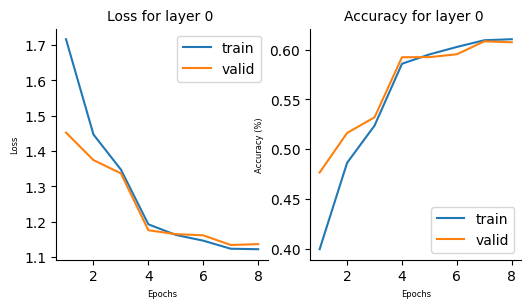

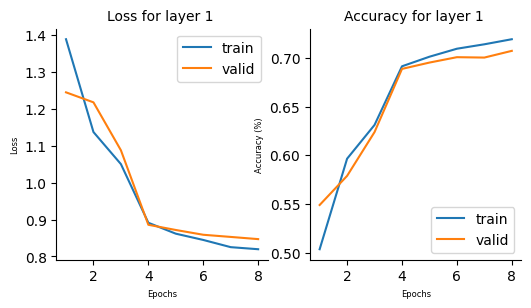

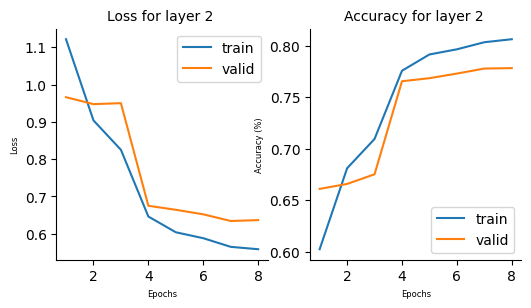

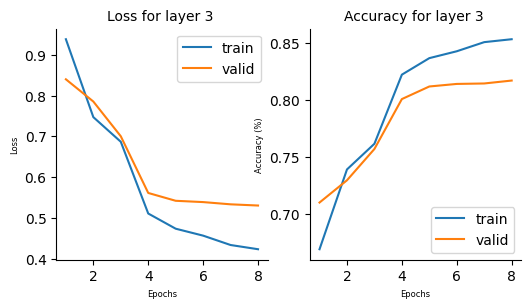

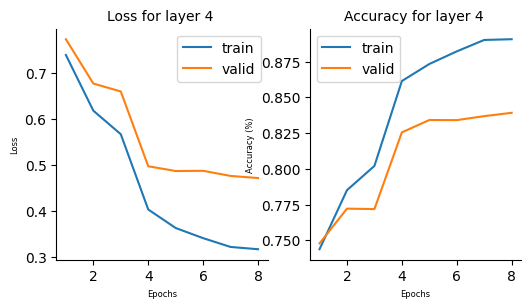

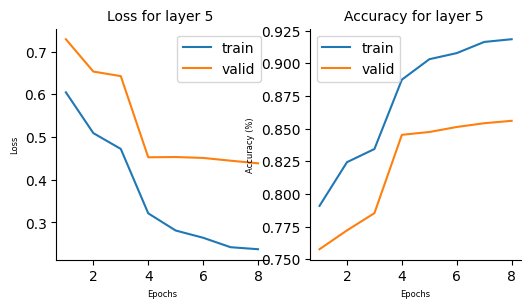

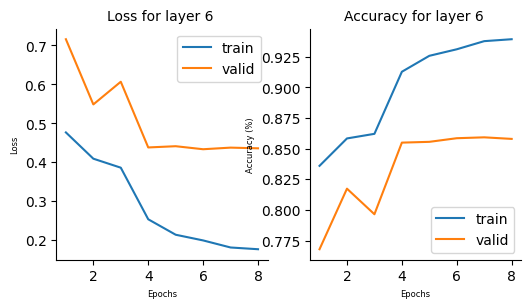

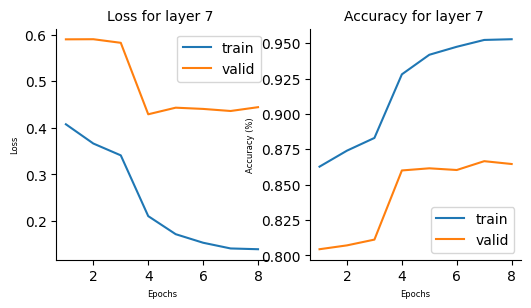

In [ ]:
train_losses =[]
train_accs =[]
valid_losses =[]
valid_accs =[]

for history in layered_histories:
  train_acc = [t.cpu() for t in history['train_acc']]
  val_acc = [t.cpu() for t in history['val_acc']]

  train_losses.append(history['train_loss'])
  train_accs.append(train_acc)
  valid_losses.append(history['val_loss'])
  valid_accs.append(val_acc)

for i in range(len(train_losses)):
  plot_layered_results(train_losses[i],train_accs[i], valid_losses[i], valid_accs[i], i)

In [ ]:
model_name = f'layered_C_layer6'
model_layered = load_pre_trained_model(os.path.join(f'{model_config_dir}/{model_name}/best_model_params.pt') , device )
model_layered.eval()
preds_ , real_ , metrics_ = evaluate_model(model_layered , test_dataloader ,device , False)
print(f'accuracy for layer: {accuracy_score(real_, preds_)}')


accuracy for layer: 0.8783


### CSI

#### load a sample of data

In [ ]:
# load a batch of size 1000 from train and test to avoid lack of memory error
X_train, y_train, X_test, y_test = sample_from_CIFAR10(train_size=300, test_size=300)


Files already downloaded and verified
Files already downloaded and verified


#### load the model

In [ ]:
model_name = f'layered_C_layer6'
model_layered = load_pre_trained_model(os.path.join(f'{model_config_dir}/{model_name}/best_model_params.pt') , device )
model_layered.eval()


Custom_VGG_11(
  (layers): Sequential(
    (layer0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (layer1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer2): ReLU()
    (layer3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (layer4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (layer5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer6): ReLU()
    (layer7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (layer8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (layer9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer10): ReLU()
    (layer11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (layer12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer13):

#### layers feature extraction

In [ ]:
leaf_layers_names =[]
for name, layer in model_layered.named_modules():
    if isinstance(layer, torch.nn.MaxPool2d):
        print(name, layer)
        leaf_layers_names.append(name)
    elif isinstance(layer, torch.nn.Linear) or  isinstance(layer, torch.nn.Flatten):
        print(name, layer)
        leaf_layers_names.append(name)

layers.layer3 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
layers.layer7 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
layers.layer14 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
layers.layer21 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
layers.layer28 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
layers.layer29 Flatten(start_dim=1, end_dim=-1)
layers.layer30 Linear(in_features=512, out_features=512, bias=True)
layers.layer31 Linear(in_features=512, out_features=10, bias=True)


In [ ]:
!nvidia-smi

Sat Dec 30 08:01:39 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P0              28W /  70W |    669MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
# extract features for train and test set
X_train, y_train = X_train.to(device), y_train.to(device)
train_intermediate_outputs = model_feature_extraction(model_layered, X_train,leaf_layers_names)
y_train = y_train.to(torch.float32)


In [ ]:
#free up memory and cache
del X_train , y_train , train_intermediate_outputs
torch.cuda.empty_cache()

In [ ]:
X_test, y_test = X_test.to(device), y_test.to(device)
test_intermediate_outputs = model_feature_extraction(model_layered, X_test,leaf_layers_names)
y_test = y_test.to(torch.float32)


In [ ]:
#free up memory and cache
del X_test , y_test ,test_intermediate_outputs
torch.cuda.empty_cache()

#### Center SI

In [ ]:
# calculate center si score of all intermediates layers outputs for train and test data
train_layer_center_si_scores = calc_center_si_score(train_intermediate_outputs, y_train, leaf_layers_names)


100%|██████████| 8/8 [00:00<00:00, 18.37it/s]


In [ ]:
test_layer_center_si_scores = calc_center_si_score(test_intermediate_outputs, y_test, leaf_layers_names)

100%|██████████| 8/8 [00:00<00:00, 27.58it/s]


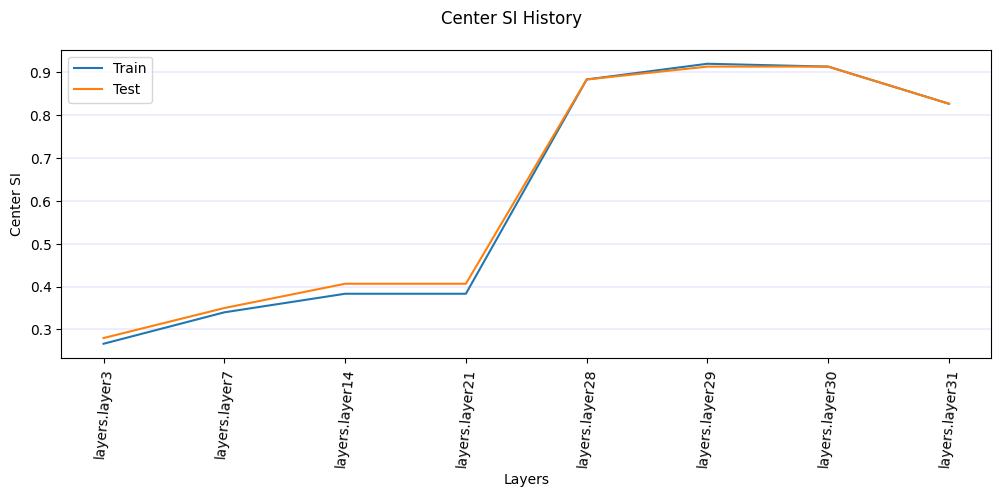

In [ ]:
# plot SI history for train and test
plt.figure(figsize=(12, 4))
plt.plot(leaf_layers_names, train_layer_center_si_scores, label='Train')
plt.plot(leaf_layers_names, test_layer_center_si_scores, label='Test')

plt.ylabel('Center SI')
plt.xlabel('Layers')
plt.xticks(rotation=85)
plt.suptitle('Center SI History')
plt.legend()
plt.grid(axis='y', color='b', linestyle='-', linewidth=0.1)
plt.show()

## D

### train

In [ ]:
model = LayeredVGG11()
model.to(device)
model_name = 'layered_D'
model, layered_histories,layered_models = train_layered_model(model, model_name, no_grad=False, part_e = False,part_d = True)

Files already downloaded and verified
Files already downloaded and verified
Epoch 0/7
--------------------


100%|██████████| 293/293 [00:33<00:00,  8.64it/s]


train Loss: 1.6767 Acc: 0.4080 LR: 0.01


100%|██████████| 98/98 [00:11<00:00,  8.84it/s]


val Loss: 1.4760 Acc: 0.4682 LR: 0.01
Saving best model with acc:  tensor(0.4682, device='cuda:0', dtype=torch.float64)

Epoch 1/7
--------------------


100%|██████████| 293/293 [00:33<00:00,  8.66it/s]


train Loss: 1.4010 Acc: 0.5035 LR: 0.01


100%|██████████| 98/98 [00:11<00:00,  8.75it/s]


val Loss: 1.3533 Acc: 0.5110 LR: 0.01
Saving best model with acc:  tensor(0.5110, device='cuda:0', dtype=torch.float64)

Epoch 2/7
--------------------


100%|██████████| 293/293 [00:34<00:00,  8.51it/s]


train Loss: 1.3211 Acc: 0.5363 LR: 0.01


100%|██████████| 98/98 [00:11<00:00,  8.75it/s]


val Loss: 1.2553 Acc: 0.5672 LR: 0.001
Saving best model with acc:  tensor(0.5672, device='cuda:0', dtype=torch.float64)

Epoch 3/7
--------------------


100%|██████████| 293/293 [00:34<00:00,  8.54it/s]


train Loss: 1.1483 Acc: 0.6061 LR: 0.001


100%|██████████| 98/98 [00:11<00:00,  8.81it/s]


val Loss: 1.1546 Acc: 0.6015 LR: 0.001
Saving best model with acc:  tensor(0.6015, device='cuda:0', dtype=torch.float64)

Epoch 4/7
--------------------


100%|██████████| 293/293 [00:34<00:00,  8.56it/s]


train Loss: 1.1202 Acc: 0.6132 LR: 0.001


100%|██████████| 98/98 [00:11<00:00,  8.72it/s]


val Loss: 1.1369 Acc: 0.6033 LR: 0.001
Saving best model with acc:  tensor(0.6033, device='cuda:0', dtype=torch.float64)

Epoch 5/7
--------------------


100%|██████████| 293/293 [00:34<00:00,  8.61it/s]


train Loss: 1.1033 Acc: 0.6188 LR: 0.001


100%|██████████| 98/98 [00:11<00:00,  8.74it/s]


val Loss: 1.1226 Acc: 0.6096 LR: 0.0001
Saving best model with acc:  tensor(0.6096, device='cuda:0', dtype=torch.float64)

Epoch 6/7
--------------------


100%|██████████| 293/293 [00:36<00:00,  7.94it/s]


train Loss: 1.0782 Acc: 0.6295 LR: 0.0001


100%|██████████| 98/98 [00:11<00:00,  8.80it/s]


val Loss: 1.1097 Acc: 0.6184 LR: 0.0001
Saving best model with acc:  tensor(0.6184, device='cuda:0', dtype=torch.float64)

Epoch 7/7
--------------------


100%|██████████| 293/293 [00:34<00:00,  8.59it/s]


train Loss: 1.0700 Acc: 0.6307 LR: 0.0001


100%|██████████| 98/98 [00:11<00:00,  8.77it/s]


val Loss: 1.1067 Acc: 0.6191 LR: 0.0001
Saving best model with acc:  tensor(0.6191, device='cuda:0', dtype=torch.float64)

Training complete in 6m 6s
Best val Acc: 0.619120
Epoch 0/7
--------------------


100%|██████████| 293/293 [00:35<00:00,  8.27it/s]


train Loss: 1.3998 Acc: 0.5033 LR: 0.01


100%|██████████| 98/98 [00:11<00:00,  8.68it/s]


val Loss: 1.2274 Acc: 0.5675 LR: 0.01
Saving best model with acc:  tensor(0.5675, device='cuda:0', dtype=torch.float64)

Epoch 1/7
--------------------


100%|██████████| 293/293 [00:35<00:00,  8.29it/s]


train Loss: 1.1205 Acc: 0.6006 LR: 0.01


100%|██████████| 98/98 [00:11<00:00,  8.61it/s]


val Loss: 1.1146 Acc: 0.6092 LR: 0.01
Saving best model with acc:  tensor(0.6092, device='cuda:0', dtype=torch.float64)

Epoch 2/7
--------------------


100%|██████████| 293/293 [00:35<00:00,  8.24it/s]


train Loss: 1.0421 Acc: 0.6326 LR: 0.01


100%|██████████| 98/98 [00:11<00:00,  8.86it/s]


val Loss: 1.1015 Acc: 0.6134 LR: 0.001
Saving best model with acc:  tensor(0.6134, device='cuda:0', dtype=torch.float64)

Epoch 3/7
--------------------


100%|██████████| 293/293 [00:36<00:00,  8.01it/s]


train Loss: 0.8918 Acc: 0.6907 LR: 0.001


100%|██████████| 98/98 [00:10<00:00,  9.48it/s]


val Loss: 0.8980 Acc: 0.6883 LR: 0.001
Saving best model with acc:  tensor(0.6883, device='cuda:0', dtype=torch.float64)

Epoch 4/7
--------------------


100%|██████████| 293/293 [00:37<00:00,  7.91it/s]


train Loss: 0.8593 Acc: 0.7016 LR: 0.001


100%|██████████| 98/98 [00:10<00:00,  9.36it/s]


val Loss: 0.8960 Acc: 0.6898 LR: 0.001
Saving best model with acc:  tensor(0.6898, device='cuda:0', dtype=torch.float64)

Epoch 5/7
--------------------


100%|██████████| 293/293 [00:36<00:00,  7.97it/s]


train Loss: 0.8428 Acc: 0.7066 LR: 0.001


100%|██████████| 98/98 [00:10<00:00,  8.91it/s]


val Loss: 0.8795 Acc: 0.6943 LR: 0.0001
Saving best model with acc:  tensor(0.6943, device='cuda:0', dtype=torch.float64)

Epoch 6/7
--------------------


100%|██████████| 293/293 [00:35<00:00,  8.23it/s]


train Loss: 0.8269 Acc: 0.7123 LR: 0.0001


100%|██████████| 98/98 [00:11<00:00,  8.49it/s]


val Loss: 0.8704 Acc: 0.6990 LR: 0.0001
Saving best model with acc:  tensor(0.6990, device='cuda:0', dtype=torch.float64)

Epoch 7/7
--------------------


100%|██████████| 293/293 [00:35<00:00,  8.23it/s]


train Loss: 0.8258 Acc: 0.7123 LR: 0.0001


100%|██████████| 98/98 [00:11<00:00,  8.56it/s]


val Loss: 0.8684 Acc: 0.6954 LR: 0.0001

Training complete in 6m 17s
Best val Acc: 0.698960
Epoch 0/7
--------------------


100%|██████████| 293/293 [00:37<00:00,  7.90it/s]


train Loss: 1.1337 Acc: 0.5997 LR: 0.01


100%|██████████| 98/98 [00:11<00:00,  8.56it/s]


val Loss: 1.0694 Acc: 0.6250 LR: 0.01
Saving best model with acc:  tensor(0.6250, device='cuda:0', dtype=torch.float64)

Epoch 1/7
--------------------


100%|██████████| 293/293 [00:38<00:00,  7.63it/s]


train Loss: 0.9072 Acc: 0.6821 LR: 0.01


100%|██████████| 98/98 [00:10<00:00,  9.51it/s]


val Loss: 0.9292 Acc: 0.6770 LR: 0.01
Saving best model with acc:  tensor(0.6770, device='cuda:0', dtype=torch.float64)

Epoch 2/7
--------------------


100%|██████████| 293/293 [00:38<00:00,  7.67it/s]


train Loss: 0.8311 Acc: 0.7097 LR: 0.01


100%|██████████| 98/98 [00:11<00:00,  8.33it/s]


val Loss: 0.8498 Acc: 0.7032 LR: 0.001
Saving best model with acc:  tensor(0.7032, device='cuda:0', dtype=torch.float64)

Epoch 3/7
--------------------


100%|██████████| 293/293 [00:37<00:00,  7.91it/s]


train Loss: 0.6462 Acc: 0.7763 LR: 0.001


100%|██████████| 98/98 [00:11<00:00,  8.34it/s]


val Loss: 0.6921 Acc: 0.7551 LR: 0.001
Saving best model with acc:  tensor(0.7551, device='cuda:0', dtype=torch.float64)

Epoch 4/7
--------------------


100%|██████████| 293/293 [00:37<00:00,  7.80it/s]


train Loss: 0.6084 Acc: 0.7900 LR: 0.001


100%|██████████| 98/98 [00:10<00:00,  8.97it/s]


val Loss: 0.6755 Acc: 0.7665 LR: 0.001
Saving best model with acc:  tensor(0.7665, device='cuda:0', dtype=torch.float64)

Epoch 5/7
--------------------


100%|██████████| 293/293 [00:38<00:00,  7.65it/s]


train Loss: 0.5904 Acc: 0.7931 LR: 0.001


100%|██████████| 98/98 [00:10<00:00,  8.99it/s]


val Loss: 0.6618 Acc: 0.7693 LR: 0.0001
Saving best model with acc:  tensor(0.7693, device='cuda:0', dtype=torch.float64)

Epoch 6/7
--------------------


100%|██████████| 293/293 [00:37<00:00,  7.78it/s]


train Loss: 0.5661 Acc: 0.8022 LR: 0.0001


100%|██████████| 98/98 [00:11<00:00,  8.63it/s]


val Loss: 0.6569 Acc: 0.7678 LR: 0.0001

Epoch 7/7
--------------------


100%|██████████| 293/293 [00:36<00:00,  7.98it/s]


train Loss: 0.5637 Acc: 0.8030 LR: 0.0001


100%|██████████| 98/98 [00:11<00:00,  8.52it/s]


val Loss: 0.6548 Acc: 0.7735 LR: 0.0001
Saving best model with acc:  tensor(0.7735, device='cuda:0', dtype=torch.float64)

Training complete in 6m 32s
Best val Acc: 0.773520
Epoch 0/7
--------------------


100%|██████████| 293/293 [00:40<00:00,  7.17it/s]


train Loss: 0.9421 Acc: 0.6653 LR: 0.01


100%|██████████| 98/98 [00:11<00:00,  8.65it/s]


val Loss: 0.8446 Acc: 0.7035 LR: 0.01
Saving best model with acc:  tensor(0.7035, device='cuda:0', dtype=torch.float64)

Epoch 1/7
--------------------


100%|██████████| 293/293 [00:38<00:00,  7.53it/s]


train Loss: 0.7665 Acc: 0.7326 LR: 0.01


100%|██████████| 98/98 [00:10<00:00,  8.91it/s]


val Loss: 0.7684 Acc: 0.7310 LR: 0.01
Saving best model with acc:  tensor(0.7310, device='cuda:0', dtype=torch.float64)

Epoch 2/7
--------------------


100%|██████████| 293/293 [00:38<00:00,  7.57it/s]


train Loss: 0.6833 Acc: 0.7605 LR: 0.01


100%|██████████| 98/98 [00:11<00:00,  8.28it/s]


val Loss: 0.7508 Acc: 0.7393 LR: 0.001
Saving best model with acc:  tensor(0.7393, device='cuda:0', dtype=torch.float64)

Epoch 3/7
--------------------


100%|██████████| 293/293 [00:37<00:00,  7.72it/s]


train Loss: 0.5145 Acc: 0.8225 LR: 0.001


100%|██████████| 98/98 [00:11<00:00,  8.46it/s]


val Loss: 0.5820 Acc: 0.7925 LR: 0.001
Saving best model with acc:  tensor(0.7925, device='cuda:0', dtype=torch.float64)

Epoch 4/7
--------------------


100%|██████████| 293/293 [00:39<00:00,  7.40it/s]


train Loss: 0.4777 Acc: 0.8346 LR: 0.001


100%|██████████| 98/98 [00:11<00:00,  8.69it/s]


val Loss: 0.5742 Acc: 0.8008 LR: 0.001
Saving best model with acc:  tensor(0.8008, device='cuda:0', dtype=torch.float64)

Epoch 5/7
--------------------


100%|██████████| 293/293 [00:39<00:00,  7.51it/s]


train Loss: 0.4576 Acc: 0.8414 LR: 0.001


100%|██████████| 98/98 [00:11<00:00,  8.20it/s]


val Loss: 0.5625 Acc: 0.8036 LR: 0.0001
Saving best model with acc:  tensor(0.8036, device='cuda:0', dtype=torch.float64)

Epoch 6/7
--------------------


100%|██████████| 293/293 [00:39<00:00,  7.49it/s]


train Loss: 0.4362 Acc: 0.8486 LR: 0.0001


100%|██████████| 98/98 [00:11<00:00,  8.67it/s]


val Loss: 0.5478 Acc: 0.8116 LR: 0.0001
Saving best model with acc:  tensor(0.8116, device='cuda:0', dtype=torch.float64)

Epoch 7/7
--------------------


100%|██████████| 293/293 [00:39<00:00,  7.36it/s]


train Loss: 0.4327 Acc: 0.8495 LR: 0.0001


100%|██████████| 98/98 [00:11<00:00,  8.25it/s]


val Loss: 0.5474 Acc: 0.8097 LR: 0.0001

Training complete in 6m 47s
Best val Acc: 0.811600
Files already downloaded and verified
Files already downloaded and verified
Epoch 0/7
--------------------


100%|██████████| 293/293 [00:34<00:00,  8.39it/s]


train Loss: 0.6628 Acc: 0.7702 LR: 0.01


100%|██████████| 98/98 [00:10<00:00,  9.31it/s]


val Loss: 0.5919 Acc: 0.7994 LR: 0.01
Saving best model with acc:  tensor(0.7994, device='cuda:0', dtype=torch.float64)

Epoch 1/7
--------------------


100%|██████████| 293/293 [00:34<00:00,  8.42it/s]


train Loss: 0.4723 Acc: 0.8351 LR: 0.01


100%|██████████| 98/98 [00:10<00:00,  9.41it/s]


val Loss: 0.8137 Acc: 0.7306 LR: 0.01

Epoch 2/7
--------------------


100%|██████████| 293/293 [00:34<00:00,  8.44it/s]


train Loss: 0.3848 Acc: 0.8647 LR: 0.01


100%|██████████| 98/98 [00:10<00:00,  9.39it/s]


val Loss: 0.5293 Acc: 0.8247 LR: 0.001
Saving best model with acc:  tensor(0.8247, device='cuda:0', dtype=torch.float64)

Epoch 3/7
--------------------


100%|██████████| 293/293 [00:34<00:00,  8.43it/s]


train Loss: 0.1656 Acc: 0.9491 LR: 0.001


100%|██████████| 98/98 [00:10<00:00,  9.30it/s]


val Loss: 0.4055 Acc: 0.8661 LR: 0.001
Saving best model with acc:  tensor(0.8661, device='cuda:0', dtype=torch.float64)

Epoch 4/7
--------------------


100%|██████████| 293/293 [00:34<00:00,  8.42it/s]


train Loss: 0.1166 Acc: 0.9669 LR: 0.001


100%|██████████| 98/98 [00:10<00:00,  9.41it/s]


val Loss: 0.4063 Acc: 0.8686 LR: 0.001
Saving best model with acc:  tensor(0.8686, device='cuda:0', dtype=torch.float64)

Epoch 5/7
--------------------


100%|██████████| 293/293 [00:35<00:00,  8.35it/s]


train Loss: 0.0918 Acc: 0.9745 LR: 0.001


100%|██████████| 98/98 [00:10<00:00,  9.44it/s]


val Loss: 0.4123 Acc: 0.8678 LR: 0.0001

Epoch 6/7
--------------------


100%|██████████| 293/293 [00:35<00:00,  8.34it/s]


train Loss: 0.0692 Acc: 0.9839 LR: 0.0001


100%|██████████| 98/98 [00:10<00:00,  9.31it/s]


val Loss: 0.4056 Acc: 0.8704 LR: 0.0001
Saving best model with acc:  tensor(0.8704, device='cuda:0', dtype=torch.float64)

Epoch 7/7
--------------------


100%|██████████| 293/293 [00:34<00:00,  8.40it/s]


train Loss: 0.0675 Acc: 0.9845 LR: 0.0001


100%|██████████| 98/98 [00:10<00:00,  9.41it/s]


val Loss: 0.4091 Acc: 0.8716 LR: 0.0001
Saving best model with acc:  tensor(0.8716, device='cuda:0', dtype=torch.float64)

Training complete in 6m 3s
Best val Acc: 0.871600
Epoch 0/7
--------------------


100%|██████████| 293/293 [00:36<00:00,  8.09it/s]


train Loss: 0.4279 Acc: 0.8518 LR: 0.01


100%|██████████| 98/98 [00:10<00:00,  9.23it/s]


val Loss: 0.6002 Acc: 0.8073 LR: 0.01
Saving best model with acc:  tensor(0.8073, device='cuda:0', dtype=torch.float64)

Epoch 1/7
--------------------


100%|██████████| 293/293 [00:36<00:00,  8.08it/s]


train Loss: 0.2846 Acc: 0.9003 LR: 0.01


100%|██████████| 98/98 [00:10<00:00,  9.28it/s]


val Loss: 0.7174 Acc: 0.7922 LR: 0.01

Epoch 2/7
--------------------


100%|██████████| 293/293 [00:38<00:00,  7.64it/s]


train Loss: 0.2173 Acc: 0.9228 LR: 0.01


100%|██████████| 98/98 [00:10<00:00,  9.72it/s]


val Loss: 0.6104 Acc: 0.8203 LR: 0.001
Saving best model with acc:  tensor(0.8203, device='cuda:0', dtype=torch.float64)

Epoch 3/7
--------------------


100%|██████████| 293/293 [00:37<00:00,  7.91it/s]


train Loss: 0.0615 Acc: 0.9828 LR: 0.001


100%|██████████| 98/98 [00:09<00:00, 10.38it/s]


val Loss: 0.4473 Acc: 0.8673 LR: 0.001
Saving best model with acc:  tensor(0.8673, device='cuda:0', dtype=torch.float64)

Epoch 4/7
--------------------


100%|██████████| 293/293 [00:37<00:00,  7.84it/s]


train Loss: 0.0297 Acc: 0.9936 LR: 0.001


100%|██████████| 98/98 [00:08<00:00, 11.04it/s]


val Loss: 0.4536 Acc: 0.8710 LR: 0.001
Saving best model with acc:  tensor(0.8710, device='cuda:0', dtype=torch.float64)

Epoch 5/7
--------------------


100%|██████████| 293/293 [00:37<00:00,  7.85it/s]


train Loss: 0.0192 Acc: 0.9970 LR: 0.001


100%|██████████| 98/98 [00:08<00:00, 11.08it/s]


val Loss: 0.4684 Acc: 0.8711 LR: 0.0001
Saving best model with acc:  tensor(0.8711, device='cuda:0', dtype=torch.float64)

Epoch 6/7
--------------------


100%|██████████| 293/293 [00:37<00:00,  7.87it/s]


train Loss: 0.0141 Acc: 0.9985 LR: 0.0001


100%|██████████| 98/98 [00:09<00:00, 10.31it/s]


val Loss: 0.4639 Acc: 0.8718 LR: 0.0001
Saving best model with acc:  tensor(0.8718, device='cuda:0', dtype=torch.float64)

Epoch 7/7
--------------------


100%|██████████| 293/293 [00:37<00:00,  7.79it/s]


train Loss: 0.0135 Acc: 0.9989 LR: 0.0001


100%|██████████| 98/98 [00:10<00:00,  9.38it/s]


val Loss: 0.4651 Acc: 0.8716 LR: 0.0001

Training complete in 6m 17s
Best val Acc: 0.871840
Epoch 0/7
--------------------


100%|██████████| 293/293 [00:38<00:00,  7.57it/s]


train Loss: 0.1931 Acc: 0.9364 LR: 0.01


100%|██████████| 98/98 [00:10<00:00,  8.98it/s]


val Loss: 0.6831 Acc: 0.8062 LR: 0.01
Saving best model with acc:  tensor(0.8062, device='cuda:0', dtype=torch.float64)

Epoch 1/7
--------------------


100%|██████████| 293/293 [00:38<00:00,  7.57it/s]


train Loss: 0.1510 Acc: 0.9468 LR: 0.01


100%|██████████| 98/98 [00:10<00:00,  9.37it/s]


val Loss: 0.7449 Acc: 0.8047 LR: 0.01

Epoch 2/7
--------------------


100%|██████████| 293/293 [00:39<00:00,  7.45it/s]


train Loss: 0.1149 Acc: 0.9599 LR: 0.01


100%|██████████| 98/98 [00:09<00:00, 10.38it/s]


val Loss: 0.6539 Acc: 0.8286 LR: 0.001
Saving best model with acc:  tensor(0.8286, device='cuda:0', dtype=torch.float64)

Epoch 3/7
--------------------


100%|██████████| 293/293 [00:39<00:00,  7.41it/s]


train Loss: 0.0315 Acc: 0.9911 LR: 0.001


100%|██████████| 98/98 [00:10<00:00,  9.20it/s]


val Loss: 0.4970 Acc: 0.8635 LR: 0.001
Saving best model with acc:  tensor(0.8635, device='cuda:0', dtype=torch.float64)

Epoch 4/7
--------------------


100%|██████████| 293/293 [00:37<00:00,  7.80it/s]


train Loss: 0.0112 Acc: 0.9984 LR: 0.001


100%|██████████| 98/98 [00:10<00:00,  9.22it/s]


val Loss: 0.5059 Acc: 0.8644 LR: 0.001
Saving best model with acc:  tensor(0.8644, device='cuda:0', dtype=torch.float64)

Epoch 5/7
--------------------


100%|██████████| 293/293 [00:37<00:00,  7.74it/s]


train Loss: 0.0074 Acc: 0.9994 LR: 0.001


100%|██████████| 98/98 [00:10<00:00,  9.65it/s]


val Loss: 0.5160 Acc: 0.8656 LR: 0.0001
Saving best model with acc:  tensor(0.8656, device='cuda:0', dtype=torch.float64)

Epoch 6/7
--------------------


100%|██████████| 293/293 [00:38<00:00,  7.56it/s]


train Loss: 0.0056 Acc: 0.9997 LR: 0.0001


100%|██████████| 98/98 [00:09<00:00, 10.78it/s]


val Loss: 0.5152 Acc: 0.8672 LR: 0.0001
Saving best model with acc:  tensor(0.8672, device='cuda:0', dtype=torch.float64)

Epoch 7/7
--------------------


100%|██████████| 293/293 [00:39<00:00,  7.50it/s]


train Loss: 0.0055 Acc: 0.9997 LR: 0.0001


100%|██████████| 98/98 [00:10<00:00,  9.56it/s]


val Loss: 0.5196 Acc: 0.8677 LR: 0.0001
Saving best model with acc:  tensor(0.8677, device='cuda:0', dtype=torch.float64)

Training complete in 6m 32s
Best val Acc: 0.867680
Epoch 0/7
--------------------


100%|██████████| 293/293 [00:39<00:00,  7.41it/s]


train Loss: 0.1083 Acc: 0.9673 LR: 0.01


100%|██████████| 98/98 [00:10<00:00,  9.00it/s]


val Loss: 0.7060 Acc: 0.8116 LR: 0.01
Saving best model with acc:  tensor(0.8116, device='cuda:0', dtype=torch.float64)

Epoch 1/7
--------------------


100%|██████████| 293/293 [00:39<00:00,  7.35it/s]


train Loss: 0.1108 Acc: 0.9626 LR: 0.01


100%|██████████| 98/98 [00:09<00:00, 10.24it/s]


val Loss: 0.8253 Acc: 0.8041 LR: 0.01

Epoch 2/7
--------------------


100%|██████████| 293/293 [00:40<00:00,  7.31it/s]


train Loss: 0.0988 Acc: 0.9662 LR: 0.01


100%|██████████| 98/98 [00:10<00:00,  9.35it/s]


val Loss: 0.7980 Acc: 0.8051 LR: 0.001

Epoch 3/7
--------------------


100%|██████████| 293/293 [00:38<00:00,  7.52it/s]


train Loss: 0.0251 Acc: 0.9926 LR: 0.001


100%|██████████| 98/98 [00:10<00:00,  8.98it/s]


val Loss: 0.5277 Acc: 0.8632 LR: 0.001
Saving best model with acc:  tensor(0.8632, device='cuda:0', dtype=torch.float64)

Epoch 4/7
--------------------


100%|██████████| 293/293 [00:41<00:00,  7.14it/s]


train Loss: 0.0086 Acc: 0.9987 LR: 0.001


100%|██████████| 98/98 [00:10<00:00,  9.65it/s]


val Loss: 0.5389 Acc: 0.8653 LR: 0.001
Saving best model with acc:  tensor(0.8653, device='cuda:0', dtype=torch.float64)

Epoch 5/7
--------------------


100%|██████████| 293/293 [00:40<00:00,  7.30it/s]


train Loss: 0.0058 Acc: 0.9992 LR: 0.001


100%|██████████| 98/98 [00:09<00:00,  9.83it/s]


val Loss: 0.5504 Acc: 0.8665 LR: 0.0001
Saving best model with acc:  tensor(0.8665, device='cuda:0', dtype=torch.float64)

Epoch 6/7
--------------------


100%|██████████| 293/293 [00:39<00:00,  7.40it/s]


train Loss: 0.0045 Acc: 0.9996 LR: 0.0001


100%|██████████| 98/98 [00:10<00:00,  9.14it/s]


val Loss: 0.5432 Acc: 0.8678 LR: 0.0001
Saving best model with acc:  tensor(0.8678, device='cuda:0', dtype=torch.float64)

Epoch 7/7
--------------------


100%|██████████| 293/293 [00:39<00:00,  7.35it/s]


train Loss: 0.0044 Acc: 0.9996 LR: 0.0001


100%|██████████| 98/98 [00:09<00:00,  9.97it/s]

val Loss: 0.5452 Acc: 0.8666 LR: 0.0001

Training complete in 6m 43s
Best val Acc: 0.867760


### evaluate

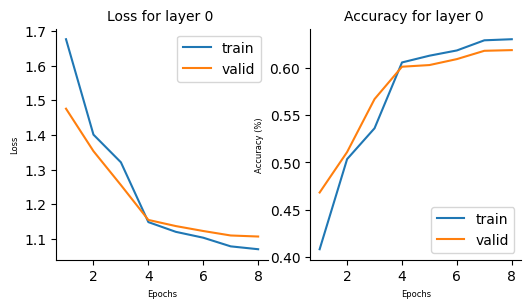

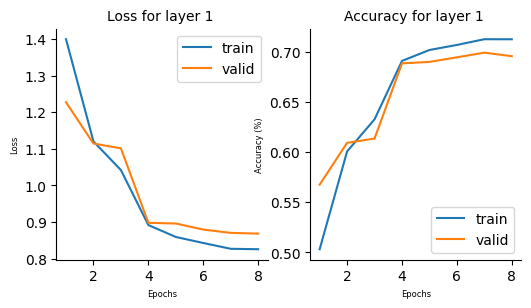

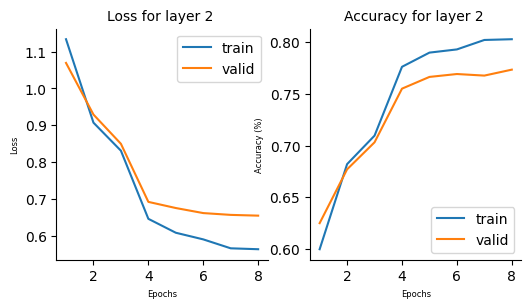

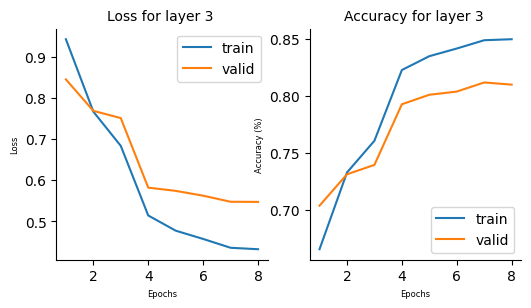

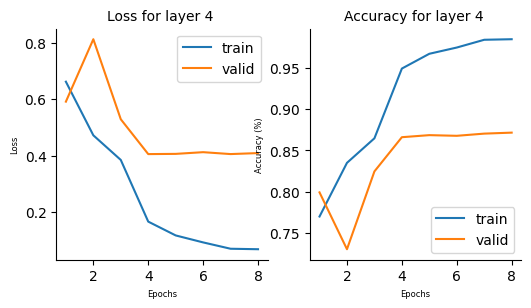

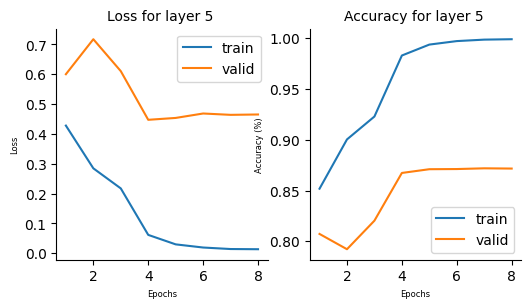

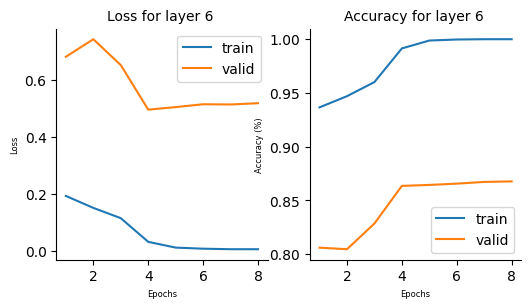

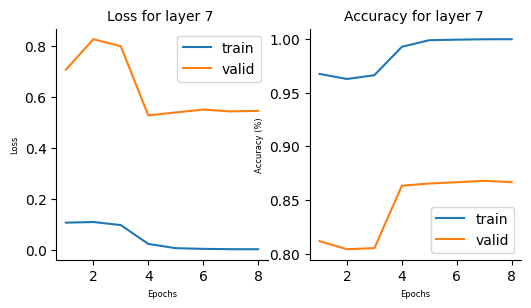

In [ ]:
train_losses =[]
train_accs =[]
valid_losses =[]
valid_accs =[]

for history in layered_histories:
  train_acc = [t.cpu() for t in history['train_acc']]
  val_acc = [t.cpu() for t in history['val_acc']]

  train_losses.append(history['train_loss'])
  train_accs.append(train_acc)
  valid_losses.append(history['val_loss'])
  valid_accs.append(val_acc)

for i in range(len(train_losses)):
  plot_layered_results(train_losses[i],train_accs[i], valid_losses[i], valid_accs[i], i)

In [ ]:
model_name = f'layered_D_layer6'
model_layered = load_pre_trained_model(os.path.join(f'{model_config_dir}/{model_name}/best_model_params.pt') , device )
model_layered.eval()
preds_ , real_ , metrics_ = evaluate_model(model_layered , test_dataloader ,device , False)
print(f'accuracy for layer: {accuracy_score(real_, preds_)}')

accuracy for layer: 0.853


### CSI

#### load a sample of data

In [ ]:
# load a batch of size 1000 from train and test to avoid lack of memory error
X_train, y_train, X_test, y_test = sample_from_CIFAR10(train_size=300, test_size=300)


Files already downloaded and verified
Files already downloaded and verified


#### load the model

In [ ]:
model_name = f'layered_D_layer6'
model_layered = load_pre_trained_model(os.path.join(f'{model_config_dir}/{model_name}/best_model_params.pt') , device )
model_layered.eval()

Custom_VGG_11(
  (layers): Sequential(
    (layer0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (layer1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer2): ReLU()
    (layer3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (layer4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (layer5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer6): ReLU()
    (layer7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (layer8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (layer9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer10): ReLU()
    (layer11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (layer12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer13):

#### layers feature extraction

In [ ]:
leaf_layers_names =[]
for name, layer in model_layered.named_modules():
    if isinstance(layer, torch.nn.MaxPool2d):
        print(name, layer)
        leaf_layers_names.append(name)
    elif isinstance(layer, torch.nn.Linear) or  isinstance(layer, torch.nn.Flatten):
        print(name, layer)
        leaf_layers_names.append(name)

layers.layer3 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
layers.layer7 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
layers.layer14 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
layers.layer21 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
layers.layer28 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
layers.layer29 Flatten(start_dim=1, end_dim=-1)
layers.layer30 Linear(in_features=512, out_features=512, bias=True)
layers.layer31 Linear(in_features=512, out_features=10, bias=True)


In [ ]:
!nvidia-smi

Sat Dec 30 08:07:27 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P0              29W /  70W |    767MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
# extract features for train and test set
X_train, y_train = X_train.to(device), y_train.to(device)
train_intermediate_outputs = model_feature_extraction(model_layered, X_train,leaf_layers_names)
y_train = y_train.to(torch.float32)


In [ ]:
#free up memory and cache
del X_train , y_train , train_intermediate_outputs
torch.cuda.empty_cache()

In [ ]:
X_test, y_test = X_test.to(device), y_test.to(device)
test_intermediate_outputs = model_feature_extraction(model_layered, X_test,leaf_layers_names)
y_test = y_test.to(torch.float32)


In [ ]:
#free up memory and cache
del X_test , y_test ,test_intermediate_outputs
torch.cuda.empty_cache()

#### Center SI

In [ ]:
# calculate center si score of all intermediates layers outputs for train and test data
train_layer_center_si_scores = calc_center_si_score(train_intermediate_outputs, y_train, leaf_layers_names)


100%|██████████| 8/8 [00:00<00:00, 27.70it/s]


In [ ]:
test_layer_center_si_scores = calc_center_si_score(test_intermediate_outputs, y_test, leaf_layers_names)

100%|██████████| 8/8 [00:00<00:00, 28.29it/s]


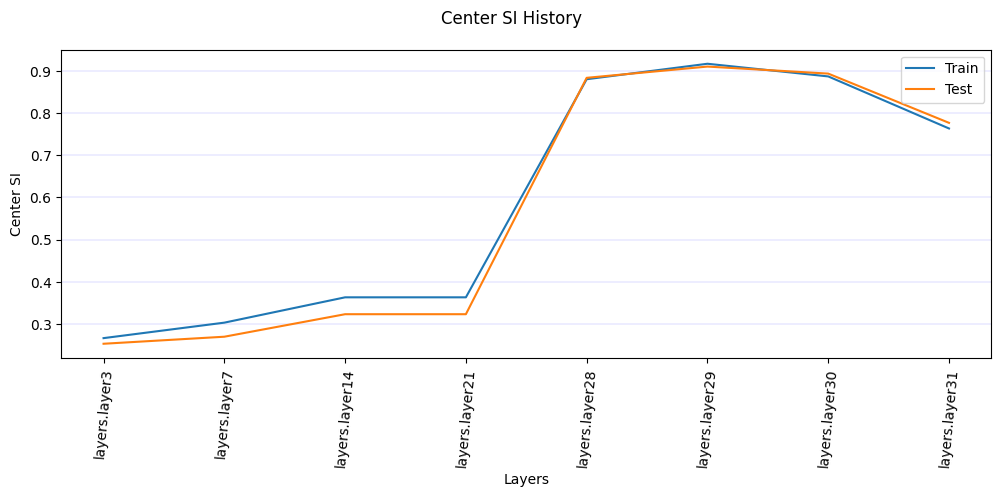

In [ ]:
# plot SI history for train and test
plt.figure(figsize=(12, 4))
plt.plot(leaf_layers_names, train_layer_center_si_scores, label='Train')
plt.plot(leaf_layers_names, test_layer_center_si_scores, label='Test')

plt.ylabel('Center SI')
plt.xlabel('Layers')
plt.xticks(rotation=85)
plt.suptitle('Center SI History')
plt.legend()
plt.grid(axis='y', color='b', linestyle='-', linewidth=0.1)
plt.show()

## E

### train

In [ ]:
model = LayeredVGG11()
model.to(device)
model_name = 'layered_E'
model, layered_histories,layered_models = train_layered_model(model, model_name, no_grad=False, part_e = True,part_d = False)

Files already downloaded and verified
Files already downloaded and verified
Epoch 0/7
--------------------


100%|██████████| 293/293 [00:29<00:00, 10.00it/s]


train Loss: 1.5868 Acc: 0.4394 LR: 0.01


100%|██████████| 98/98 [00:09<00:00, 10.34it/s]


val Loss: 1.3724 Acc: 0.5083 LR: 0.01
Saving best model with acc:  tensor(0.5083, device='cuda:0', dtype=torch.float64)

Epoch 1/7
--------------------


100%|██████████| 293/293 [00:28<00:00, 10.26it/s]


train Loss: 1.2827 Acc: 0.5510 LR: 0.01


100%|██████████| 98/98 [00:09<00:00, 10.48it/s]


val Loss: 1.2327 Acc: 0.5667 LR: 0.01
Saving best model with acc:  tensor(0.5667, device='cuda:0', dtype=torch.float64)

Epoch 2/7
--------------------


100%|██████████| 293/293 [00:30<00:00,  9.53it/s]


train Loss: 1.1418 Acc: 0.6039 LR: 0.01


100%|██████████| 98/98 [00:09<00:00, 10.66it/s]


val Loss: 1.1555 Acc: 0.5938 LR: 0.001
Saving best model with acc:  tensor(0.5938, device='cuda:0', dtype=torch.float64)

Epoch 3/7
--------------------


100%|██████████| 293/293 [00:29<00:00, 10.10it/s]


train Loss: 0.9094 Acc: 0.6892 LR: 0.001


100%|██████████| 98/98 [00:10<00:00,  9.41it/s]


val Loss: 1.0265 Acc: 0.6447 LR: 0.001
Saving best model with acc:  tensor(0.6447, device='cuda:0', dtype=torch.float64)

Epoch 4/7
--------------------


100%|██████████| 293/293 [00:29<00:00,  9.82it/s]


train Loss: 0.8678 Acc: 0.7043 LR: 0.001


100%|██████████| 98/98 [00:08<00:00, 11.91it/s]


val Loss: 1.0221 Acc: 0.6511 LR: 0.001
Saving best model with acc:  tensor(0.6511, device='cuda:0', dtype=torch.float64)

Epoch 5/7
--------------------


100%|██████████| 293/293 [00:29<00:00,  9.81it/s]


train Loss: 0.8484 Acc: 0.7109 LR: 0.001


100%|██████████| 98/98 [00:09<00:00, 10.03it/s]


val Loss: 1.0189 Acc: 0.6575 LR: 0.0001
Saving best model with acc:  tensor(0.6575, device='cuda:0', dtype=torch.float64)

Epoch 6/7
--------------------


100%|██████████| 293/293 [00:30<00:00,  9.53it/s]


train Loss: 0.8124 Acc: 0.7256 LR: 0.0001


100%|██████████| 98/98 [00:08<00:00, 11.68it/s]


val Loss: 1.0119 Acc: 0.6537 LR: 0.0001

Epoch 7/7
--------------------


100%|██████████| 293/293 [00:28<00:00, 10.27it/s]


train Loss: 0.8094 Acc: 0.7261 LR: 0.0001


100%|██████████| 98/98 [00:09<00:00,  9.93it/s]


val Loss: 1.0031 Acc: 0.6566 LR: 0.0001

Training complete in 5m 12s
Best val Acc: 0.657520
Epoch 0/7
--------------------


100%|██████████| 293/293 [00:30<00:00,  9.55it/s]


train Loss: 1.2635 Acc: 0.5559 LR: 0.01


100%|██████████| 98/98 [00:09<00:00, 10.15it/s]


val Loss: 1.0709 Acc: 0.6212 LR: 0.01
Saving best model with acc:  tensor(0.6212, device='cuda:0', dtype=torch.float64)

Epoch 1/7
--------------------


100%|██████████| 293/293 [00:29<00:00,  9.98it/s]


train Loss: 0.9686 Acc: 0.6648 LR: 0.01


100%|██████████| 98/98 [00:07<00:00, 12.51it/s]


val Loss: 0.9776 Acc: 0.6600 LR: 0.01
Saving best model with acc:  tensor(0.6600, device='cuda:0', dtype=torch.float64)

Epoch 2/7
--------------------


100%|██████████| 293/293 [00:31<00:00,  9.34it/s]


train Loss: 0.8739 Acc: 0.6976 LR: 0.01


100%|██████████| 98/98 [00:10<00:00,  9.69it/s]


val Loss: 0.8833 Acc: 0.6946 LR: 0.001
Saving best model with acc:  tensor(0.6946, device='cuda:0', dtype=torch.float64)

Epoch 3/7
--------------------


100%|██████████| 293/293 [00:29<00:00,  9.89it/s]


train Loss: 0.6664 Acc: 0.7728 LR: 0.001


100%|██████████| 98/98 [00:08<00:00, 10.93it/s]


val Loss: 0.7744 Acc: 0.7342 LR: 0.001
Saving best model with acc:  tensor(0.7342, device='cuda:0', dtype=torch.float64)

Epoch 4/7
--------------------


100%|██████████| 293/293 [00:30<00:00,  9.64it/s]


train Loss: 0.6271 Acc: 0.7871 LR: 0.001


100%|██████████| 98/98 [00:08<00:00, 10.89it/s]


val Loss: 0.7721 Acc: 0.7358 LR: 0.001
Saving best model with acc:  tensor(0.7358, device='cuda:0', dtype=torch.float64)

Epoch 5/7
--------------------


100%|██████████| 293/293 [00:30<00:00,  9.61it/s]


train Loss: 0.6060 Acc: 0.7945 LR: 0.001


100%|██████████| 98/98 [00:09<00:00, 10.29it/s]


val Loss: 0.7619 Acc: 0.7397 LR: 0.0001
Saving best model with acc:  tensor(0.7397, device='cuda:0', dtype=torch.float64)

Epoch 6/7
--------------------


100%|██████████| 293/293 [00:29<00:00,  9.99it/s]


train Loss: 0.5731 Acc: 0.8085 LR: 0.0001


100%|██████████| 98/98 [00:07<00:00, 12.33it/s]


val Loss: 0.7533 Acc: 0.7412 LR: 0.0001
Saving best model with acc:  tensor(0.7412, device='cuda:0', dtype=torch.float64)

Epoch 7/7
--------------------


100%|██████████| 293/293 [00:32<00:00,  9.07it/s]


train Loss: 0.5708 Acc: 0.8077 LR: 0.0001


100%|██████████| 98/98 [00:09<00:00, 10.42it/s]


val Loss: 0.7529 Acc: 0.7421 LR: 0.0001
Saving best model with acc:  tensor(0.7421, device='cuda:0', dtype=torch.float64)

Training complete in 5m 17s
Best val Acc: 0.742080
Epoch 0/7
--------------------


100%|██████████| 293/293 [00:30<00:00,  9.48it/s]


train Loss: 0.9861 Acc: 0.6575 LR: 0.01


100%|██████████| 98/98 [00:09<00:00, 10.17it/s]


val Loss: 0.8594 Acc: 0.7048 LR: 0.01
Saving best model with acc:  tensor(0.7048, device='cuda:0', dtype=torch.float64)

Epoch 1/7
--------------------


100%|██████████| 293/293 [00:32<00:00,  9.08it/s]


train Loss: 0.7193 Acc: 0.7496 LR: 0.01


100%|██████████| 98/98 [00:10<00:00,  9.73it/s]


val Loss: 0.8121 Acc: 0.7238 LR: 0.01
Saving best model with acc:  tensor(0.7238, device='cuda:0', dtype=torch.float64)

Epoch 2/7
--------------------


100%|██████████| 293/293 [00:32<00:00,  9.15it/s]


train Loss: 0.6008 Acc: 0.7895 LR: 0.01


100%|██████████| 98/98 [00:08<00:00, 12.19it/s]


val Loss: 0.8295 Acc: 0.7210 LR: 0.001

Epoch 3/7
--------------------


100%|██████████| 293/293 [00:31<00:00,  9.38it/s]


train Loss: 0.3650 Acc: 0.8800 LR: 0.001


100%|██████████| 98/98 [00:09<00:00, 10.37it/s]


val Loss: 0.6018 Acc: 0.7975 LR: 0.001
Saving best model with acc:  tensor(0.7975, device='cuda:0', dtype=torch.float64)

Epoch 4/7
--------------------


100%|██████████| 293/293 [00:32<00:00,  9.00it/s]


train Loss: 0.3006 Acc: 0.9035 LR: 0.001


100%|██████████| 98/98 [00:10<00:00,  9.69it/s]


val Loss: 0.5986 Acc: 0.8022 LR: 0.001
Saving best model with acc:  tensor(0.8022, device='cuda:0', dtype=torch.float64)

Epoch 5/7
--------------------


100%|██████████| 293/293 [00:31<00:00,  9.22it/s]


train Loss: 0.2695 Acc: 0.9143 LR: 0.001


100%|██████████| 98/98 [00:09<00:00, 10.55it/s]


val Loss: 0.5906 Acc: 0.8029 LR: 0.0001
Saving best model with acc:  tensor(0.8029, device='cuda:0', dtype=torch.float64)

Epoch 6/7
--------------------


100%|██████████| 293/293 [00:30<00:00,  9.49it/s]


train Loss: 0.2344 Acc: 0.9297 LR: 0.0001


100%|██████████| 98/98 [00:07<00:00, 12.30it/s]


val Loss: 0.5818 Acc: 0.8062 LR: 0.0001
Saving best model with acc:  tensor(0.8062, device='cuda:0', dtype=torch.float64)

Epoch 7/7
--------------------


100%|██████████| 293/293 [00:33<00:00,  8.79it/s]


train Loss: 0.2299 Acc: 0.9310 LR: 0.0001


100%|██████████| 98/98 [00:09<00:00, 10.21it/s]


val Loss: 0.5849 Acc: 0.8059 LR: 0.0001

Training complete in 5m 30s
Best val Acc: 0.806240
Epoch 0/7
--------------------


100%|██████████| 293/293 [00:31<00:00,  9.27it/s]


train Loss: 0.8022 Acc: 0.7175 LR: 0.01


100%|██████████| 98/98 [00:09<00:00, 10.05it/s]


val Loss: 0.9030 Acc: 0.6974 LR: 0.01
Saving best model with acc:  tensor(0.6974, device='cuda:0', dtype=torch.float64)

Epoch 1/7
--------------------


100%|██████████| 293/293 [00:32<00:00,  9.10it/s]


train Loss: 0.5635 Acc: 0.8054 LR: 0.01


100%|██████████| 98/98 [00:10<00:00,  9.34it/s]


val Loss: 0.7936 Acc: 0.7348 LR: 0.01
Saving best model with acc:  tensor(0.7348, device='cuda:0', dtype=torch.float64)

Epoch 2/7
--------------------


100%|██████████| 293/293 [00:32<00:00,  8.91it/s]


train Loss: 0.4433 Acc: 0.8466 LR: 0.01


100%|██████████| 98/98 [00:09<00:00, 10.78it/s]


val Loss: 0.7915 Acc: 0.7568 LR: 0.001
Saving best model with acc:  tensor(0.7568, device='cuda:0', dtype=torch.float64)

Epoch 3/7
--------------------


100%|██████████| 293/293 [00:32<00:00,  9.14it/s]


train Loss: 0.2129 Acc: 0.9319 LR: 0.001


100%|██████████| 98/98 [00:08<00:00, 11.57it/s]


val Loss: 0.4921 Acc: 0.8336 LR: 0.001
Saving best model with acc:  tensor(0.8336, device='cuda:0', dtype=torch.float64)

Epoch 4/7
--------------------


100%|██████████| 293/293 [00:35<00:00,  8.17it/s]


train Loss: 0.1587 Acc: 0.9531 LR: 0.001


100%|██████████| 98/98 [00:09<00:00, 10.33it/s]


val Loss: 0.4925 Acc: 0.8385 LR: 0.001
Saving best model with acc:  tensor(0.8385, device='cuda:0', dtype=torch.float64)

Epoch 5/7
--------------------


100%|██████████| 293/293 [00:31<00:00,  9.26it/s]


train Loss: 0.1314 Acc: 0.9621 LR: 0.001


100%|██████████| 98/98 [00:09<00:00, 10.12it/s]


val Loss: 0.5152 Acc: 0.8346 LR: 0.0001

Epoch 6/7
--------------------


100%|██████████| 293/293 [00:31<00:00,  9.16it/s]


train Loss: 0.1048 Acc: 0.9738 LR: 0.0001


100%|██████████| 98/98 [00:10<00:00,  9.34it/s]


val Loss: 0.4935 Acc: 0.8412 LR: 0.0001
Saving best model with acc:  tensor(0.8412, device='cuda:0', dtype=torch.float64)

Epoch 7/7
--------------------


100%|██████████| 293/293 [00:33<00:00,  8.82it/s]


train Loss: 0.1025 Acc: 0.9741 LR: 0.0001


100%|██████████| 98/98 [00:09<00:00, 10.73it/s]


val Loss: 0.4913 Acc: 0.8404 LR: 0.0001

Training complete in 5m 39s
Best val Acc: 0.841200
Files already downloaded and verified
Files already downloaded and verified
Epoch 0/7
--------------------


100%|██████████| 293/293 [00:39<00:00,  7.40it/s]


train Loss: 0.7985 Acc: 0.7239 LR: 0.01


100%|██████████| 98/98 [00:11<00:00,  8.19it/s]


val Loss: 0.7971 Acc: 0.7176 LR: 0.01
Saving best model with acc:  tensor(0.7176, device='cuda:0', dtype=torch.float64)

Epoch 1/7
--------------------


100%|██████████| 293/293 [00:39<00:00,  7.38it/s]


train Loss: 0.6425 Acc: 0.7784 LR: 0.01


100%|██████████| 98/98 [00:10<00:00,  9.10it/s]


val Loss: 0.7086 Acc: 0.7562 LR: 0.01
Saving best model with acc:  tensor(0.7562, device='cuda:0', dtype=torch.float64)

Epoch 2/7
--------------------


100%|██████████| 293/293 [00:39<00:00,  7.49it/s]


train Loss: 0.5922 Acc: 0.7951 LR: 0.01


100%|██████████| 98/98 [00:12<00:00,  8.04it/s]


val Loss: 0.7513 Acc: 0.7488 LR: 0.001

Epoch 3/7
--------------------


100%|██████████| 293/293 [00:39<00:00,  7.35it/s]


train Loss: 0.4235 Acc: 0.8540 LR: 0.001


100%|██████████| 98/98 [00:09<00:00,  9.84it/s]


val Loss: 0.4737 Acc: 0.8370 LR: 0.001
Saving best model with acc:  tensor(0.8370, device='cuda:0', dtype=torch.float64)

Epoch 4/7
--------------------


100%|██████████| 293/293 [00:39<00:00,  7.34it/s]


train Loss: 0.3813 Acc: 0.8687 LR: 0.001


100%|██████████| 98/98 [00:12<00:00,  8.07it/s]


val Loss: 0.4621 Acc: 0.8397 LR: 0.001
Saving best model with acc:  tensor(0.8397, device='cuda:0', dtype=torch.float64)

Epoch 5/7
--------------------


100%|██████████| 293/293 [00:39<00:00,  7.44it/s]


train Loss: 0.3613 Acc: 0.8743 LR: 0.001


100%|██████████| 98/98 [00:10<00:00,  9.05it/s]


val Loss: 0.4545 Acc: 0.8413 LR: 0.0001
Saving best model with acc:  tensor(0.8413, device='cuda:0', dtype=torch.float64)

Epoch 6/7
--------------------


100%|██████████| 293/293 [00:40<00:00,  7.32it/s]


train Loss: 0.3391 Acc: 0.8814 LR: 0.0001


100%|██████████| 98/98 [00:12<00:00,  8.02it/s]


val Loss: 0.4436 Acc: 0.8445 LR: 0.0001
Saving best model with acc:  tensor(0.8445, device='cuda:0', dtype=torch.float64)

Epoch 7/7
--------------------


100%|██████████| 293/293 [00:39<00:00,  7.51it/s]


train Loss: 0.3373 Acc: 0.8830 LR: 0.0001


100%|██████████| 98/98 [00:11<00:00,  8.44it/s]


val Loss: 0.4460 Acc: 0.8482 LR: 0.0001
Saving best model with acc:  tensor(0.8482, device='cuda:0', dtype=torch.float64)

Training complete in 6m 49s
Best val Acc: 0.848160
Epoch 0/7
--------------------


100%|██████████| 293/293 [00:40<00:00,  7.22it/s]


train Loss: 0.6353 Acc: 0.7817 LR: 0.01


100%|██████████| 98/98 [00:12<00:00,  7.70it/s]


val Loss: 0.5772 Acc: 0.7965 LR: 0.01
Saving best model with acc:  tensor(0.7965, device='cuda:0', dtype=torch.float64)

Epoch 1/7
--------------------


100%|██████████| 293/293 [00:41<00:00,  7.07it/s]


train Loss: 0.5224 Acc: 0.8184 LR: 0.01


100%|██████████| 98/98 [00:11<00:00,  8.71it/s]


val Loss: 0.6704 Acc: 0.7704 LR: 0.01

Epoch 2/7
--------------------


100%|██████████| 293/293 [00:41<00:00,  7.10it/s]


train Loss: 0.4859 Acc: 0.8302 LR: 0.01


100%|██████████| 98/98 [00:12<00:00,  7.96it/s]


val Loss: 0.9305 Acc: 0.7117 LR: 0.001

Epoch 3/7
--------------------


100%|██████████| 293/293 [00:41<00:00,  7.05it/s]


train Loss: 0.3443 Acc: 0.8825 LR: 0.001


100%|██████████| 98/98 [00:11<00:00,  8.63it/s]


val Loss: 0.4397 Acc: 0.8493 LR: 0.001
Saving best model with acc:  tensor(0.8493, device='cuda:0', dtype=torch.float64)

Epoch 4/7
--------------------


100%|██████████| 293/293 [00:41<00:00,  7.05it/s]


train Loss: 0.2957 Acc: 0.8981 LR: 0.001


100%|██████████| 98/98 [00:11<00:00,  8.84it/s]


val Loss: 0.4304 Acc: 0.8527 LR: 0.001
Saving best model with acc:  tensor(0.8527, device='cuda:0', dtype=torch.float64)

Epoch 5/7
--------------------


100%|██████████| 293/293 [00:41<00:00,  7.04it/s]


train Loss: 0.2830 Acc: 0.9030 LR: 0.001


100%|██████████| 98/98 [00:11<00:00,  8.64it/s]


val Loss: 0.4318 Acc: 0.8490 LR: 0.0001

Epoch 6/7
--------------------


100%|██████████| 293/293 [00:40<00:00,  7.26it/s]


train Loss: 0.2648 Acc: 0.9089 LR: 0.0001


100%|██████████| 98/98 [00:12<00:00,  8.11it/s]


val Loss: 0.4253 Acc: 0.8515 LR: 0.0001

Epoch 7/7
--------------------


100%|██████████| 293/293 [00:40<00:00,  7.21it/s]


train Loss: 0.2539 Acc: 0.9118 LR: 0.0001


100%|██████████| 98/98 [00:11<00:00,  8.63it/s]


val Loss: 0.4183 Acc: 0.8562 LR: 0.0001
Saving best model with acc:  tensor(0.8562, device='cuda:0', dtype=torch.float64)

Training complete in 7m 3s
Best val Acc: 0.856240
Epoch 0/7
--------------------


100%|██████████| 293/293 [00:42<00:00,  6.89it/s]


train Loss: 0.4931 Acc: 0.8313 LR: 0.01


100%|██████████| 98/98 [00:11<00:00,  8.17it/s]


val Loss: 0.5937 Acc: 0.7989 LR: 0.01
Saving best model with acc:  tensor(0.7989, device='cuda:0', dtype=torch.float64)

Epoch 1/7
--------------------


100%|██████████| 293/293 [00:41<00:00,  6.99it/s]


train Loss: 0.4304 Acc: 0.8510 LR: 0.01


100%|██████████| 98/98 [00:11<00:00,  8.91it/s]


val Loss: 0.5877 Acc: 0.7993 LR: 0.01
Saving best model with acc:  tensor(0.7993, device='cuda:0', dtype=torch.float64)

Epoch 2/7
--------------------


100%|██████████| 293/293 [00:43<00:00,  6.72it/s]


train Loss: 0.4061 Acc: 0.8599 LR: 0.01


100%|██████████| 98/98 [00:11<00:00,  8.75it/s]


val Loss: 0.5595 Acc: 0.8098 LR: 0.001
Saving best model with acc:  tensor(0.8098, device='cuda:0', dtype=torch.float64)

Epoch 3/7
--------------------


100%|██████████| 293/293 [00:42<00:00,  6.93it/s]


train Loss: 0.2731 Acc: 0.9067 LR: 0.001


100%|██████████| 98/98 [00:10<00:00,  8.93it/s]


val Loss: 0.4173 Acc: 0.8575 LR: 0.001
Saving best model with acc:  tensor(0.8575, device='cuda:0', dtype=torch.float64)

Epoch 4/7
--------------------


100%|██████████| 293/293 [00:43<00:00,  6.78it/s]


train Loss: 0.2320 Acc: 0.9207 LR: 0.001


100%|██████████| 98/98 [00:11<00:00,  8.17it/s]


val Loss: 0.4127 Acc: 0.8602 LR: 0.001
Saving best model with acc:  tensor(0.8602, device='cuda:0', dtype=torch.float64)

Epoch 5/7
--------------------


100%|██████████| 293/293 [00:41<00:00,  6.99it/s]


train Loss: 0.2160 Acc: 0.9259 LR: 0.001


100%|██████████| 98/98 [00:11<00:00,  8.52it/s]


val Loss: 0.4097 Acc: 0.8612 LR: 0.0001
Saving best model with acc:  tensor(0.8612, device='cuda:0', dtype=torch.float64)

Epoch 6/7
--------------------


100%|██████████| 293/293 [00:42<00:00,  6.82it/s]


train Loss: 0.1978 Acc: 0.9315 LR: 0.0001


100%|██████████| 98/98 [00:12<00:00,  8.05it/s]


val Loss: 0.4074 Acc: 0.8643 LR: 0.0001
Saving best model with acc:  tensor(0.8643, device='cuda:0', dtype=torch.float64)

Epoch 7/7
--------------------


100%|██████████| 293/293 [00:42<00:00,  6.97it/s]


train Loss: 0.1992 Acc: 0.9325 LR: 0.0001


100%|██████████| 98/98 [00:11<00:00,  8.32it/s]


val Loss: 0.4003 Acc: 0.8638 LR: 0.0001

Training complete in 7m 14s
Best val Acc: 0.864320
Epoch 0/7
--------------------


100%|██████████| 293/293 [00:44<00:00,  6.52it/s]


train Loss: 0.4247 Acc: 0.8574 LR: 0.01


100%|██████████| 98/98 [00:12<00:00,  8.05it/s]


val Loss: 0.5323 Acc: 0.8197 LR: 0.01
Saving best model with acc:  tensor(0.8197, device='cuda:0', dtype=torch.float64)

Epoch 1/7
--------------------


100%|██████████| 293/293 [00:43<00:00,  6.77it/s]


train Loss: 0.3816 Acc: 0.8684 LR: 0.01


100%|██████████| 98/98 [00:11<00:00,  8.34it/s]


val Loss: 0.6299 Acc: 0.7918 LR: 0.01

Epoch 2/7
--------------------


100%|██████████| 293/293 [00:44<00:00,  6.56it/s]


train Loss: 0.3548 Acc: 0.8770 LR: 0.01


100%|██████████| 98/98 [00:12<00:00,  8.04it/s]


val Loss: 0.5310 Acc: 0.8202 LR: 0.001
Saving best model with acc:  tensor(0.8202, device='cuda:0', dtype=torch.float64)

Epoch 3/7
--------------------


100%|██████████| 293/293 [00:43<00:00,  6.78it/s]


train Loss: 0.2280 Acc: 0.9221 LR: 0.001


100%|██████████| 98/98 [00:11<00:00,  8.30it/s]


val Loss: 0.4144 Acc: 0.8613 LR: 0.001
Saving best model with acc:  tensor(0.8613, device='cuda:0', dtype=torch.float64)

Epoch 4/7
--------------------


100%|██████████| 293/293 [00:45<00:00,  6.50it/s]


train Loss: 0.1909 Acc: 0.9351 LR: 0.001


100%|██████████| 98/98 [00:12<00:00,  8.05it/s]


val Loss: 0.4158 Acc: 0.8623 LR: 0.001
Saving best model with acc:  tensor(0.8623, device='cuda:0', dtype=torch.float64)

Epoch 5/7
--------------------


100%|██████████| 293/293 [00:44<00:00,  6.54it/s]


train Loss: 0.1782 Acc: 0.9395 LR: 0.001


100%|██████████| 98/98 [00:11<00:00,  8.64it/s]


val Loss: 0.4205 Acc: 0.8624 LR: 0.0001
Saving best model with acc:  tensor(0.8624, device='cuda:0', dtype=torch.float64)

Epoch 6/7
--------------------


100%|██████████| 293/293 [00:45<00:00,  6.40it/s]


train Loss: 0.1562 Acc: 0.9474 LR: 0.0001


100%|██████████| 98/98 [00:11<00:00,  8.41it/s]


val Loss: 0.4055 Acc: 0.8690 LR: 0.0001
Saving best model with acc:  tensor(0.8690, device='cuda:0', dtype=torch.float64)

Epoch 7/7
--------------------


100%|██████████| 293/293 [00:43<00:00,  6.69it/s]


train Loss: 0.1512 Acc: 0.9497 LR: 0.0001


100%|██████████| 98/98 [00:10<00:00,  9.04it/s]


val Loss: 0.4124 Acc: 0.8647 LR: 0.0001

Training complete in 7m 30s
Best val Acc: 0.869040


### evaluate

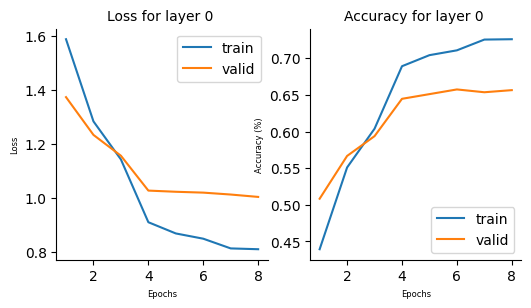

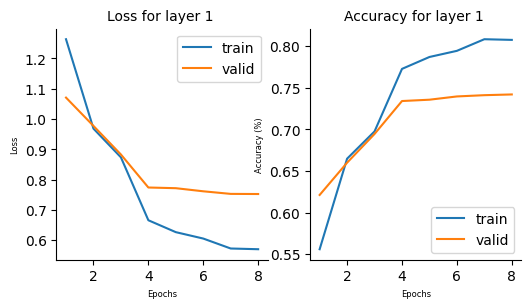

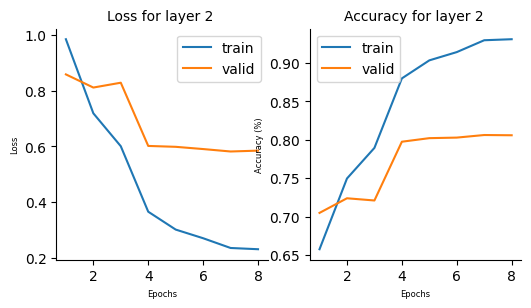

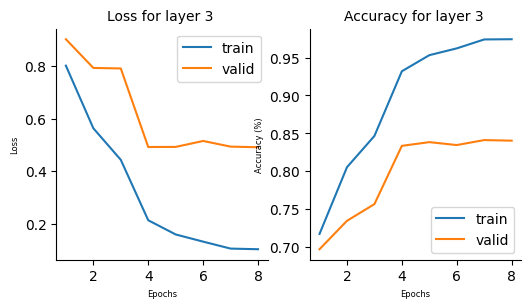

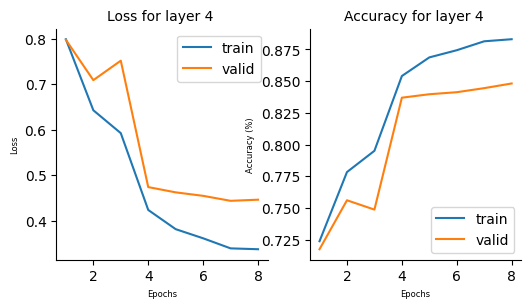

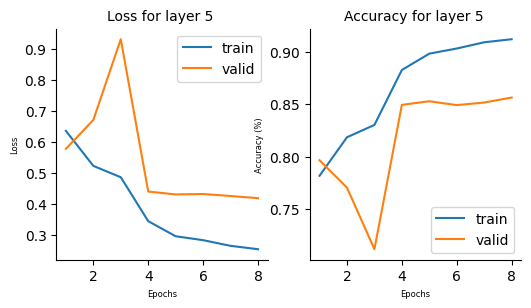

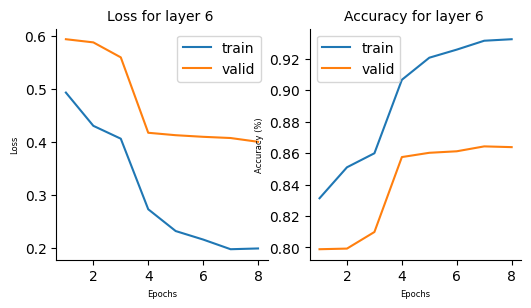

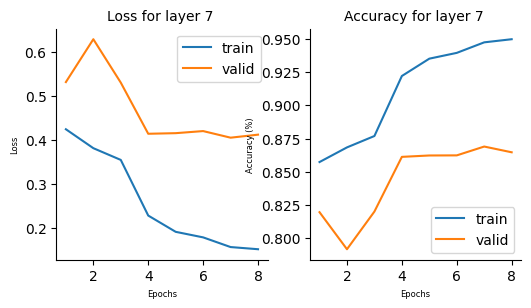

In [ ]:
train_losses =[]
train_accs =[]
valid_losses =[]
valid_accs =[]

for history in layered_histories:
  train_acc = [t.cpu() for t in history['train_acc']]
  val_acc = [t.cpu() for t in history['val_acc']]

  train_losses.append(history['train_loss'])
  train_accs.append(train_acc)
  valid_losses.append(history['val_loss'])
  valid_accs.append(val_acc)

for i in range(len(train_losses)):
  plot_layered_results(train_losses[i],train_accs[i], valid_losses[i], valid_accs[i], i)

In [ ]:
model_name = f'layered_E_layer6'
model_layered = load_pre_trained_model(os.path.join(f'{model_config_dir}/{model_name}/best_model_params.pt') , device )
model_layered.eval()
preds_ , real_ , metrics_ = evaluate_model(model_layered , test_dataloader ,device , False)
print(f'accuracy for layer: {accuracy_score(real_, preds_)}')

accuracy for layer: 0.8784


### CSI

#### load a sample of data

In [ ]:
# load a batch of size 1000 from train and test to avoid lack of memory error
X_train, y_train, X_test, y_test = sample_from_CIFAR10(train_size=300, test_size=300)


Files already downloaded and verified
Files already downloaded and verified


#### load the model

In [ ]:
model_name = f'layered_E_layer6'
model_layered = load_pre_trained_model(os.path.join(f'{model_config_dir}/{model_name}/best_model_params.pt') , device )
model_layered.eval()

Custom_VGG_11(
  (layers): Sequential(
    (layer0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (layer1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer2): ReLU()
    (layer3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (layer4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (layer5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer6): ReLU()
    (layer7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (layer8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (layer9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer10): ReLU()
    (layer11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (layer12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer13):

#### layers feature extraction

In [ ]:
leaf_layers_names =[]
for name, layer in model_layered.named_modules():
    if isinstance(layer, torch.nn.MaxPool2d):
        print(name, layer)
        leaf_layers_names.append(name)
    elif isinstance(layer, torch.nn.Linear) or  isinstance(layer, torch.nn.Flatten):
        print(name, layer)
        leaf_layers_names.append(name)

layers.layer3 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
layers.layer7 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
layers.layer14 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
layers.layer21 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
layers.layer28 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
layers.layer29 Flatten(start_dim=1, end_dim=-1)
layers.layer30 Linear(in_features=512, out_features=512, bias=True)
layers.layer31 Linear(in_features=512, out_features=10, bias=True)


In [ ]:
!nvidia-smi

Sat Dec 30 08:10:48 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P0              30W /  70W |    767MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
# extract features for train and test set
X_train, y_train = X_train.to(device), y_train.to(device)
train_intermediate_outputs = model_feature_extraction(model_layered, X_train,leaf_layers_names)
y_train = y_train.to(torch.float32)


In [ ]:
#free up memory and cache
del X_train , y_train , train_intermediate_outputs
torch.cuda.empty_cache()

In [ ]:
X_test, y_test = X_test.to(device), y_test.to(device)
test_intermediate_outputs = model_feature_extraction(model_layered, X_test,leaf_layers_names)
y_test = y_test.to(torch.float32)


In [ ]:
#free up memory and cache
del X_test , y_test ,test_intermediate_outputs
torch.cuda.empty_cache()

#### Center SI

In [ ]:
# calculate si score of all intermediates layers outputs for train and test data
train_layer_center_si_scores = calc_center_si_score(train_intermediate_outputs, y_train, leaf_layers_names)

100%|██████████| 8/8 [00:00<00:00, 26.40it/s]


In [ ]:
test_layer_center_si_scores = calc_center_si_score(test_intermediate_outputs, y_test, leaf_layers_names)


100%|██████████| 8/8 [00:00<00:00, 28.01it/s]


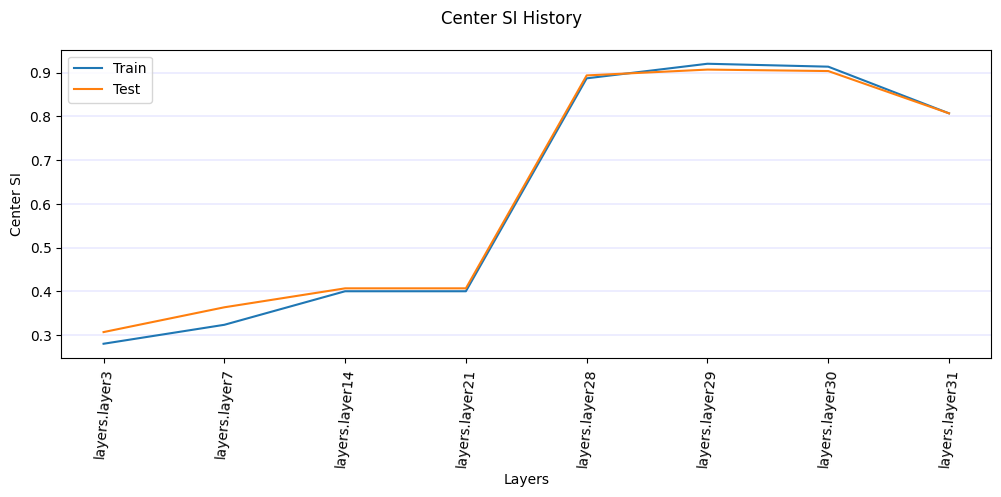

In [ ]:
# plot SI history for train and test
plt.figure(figsize=(12, 4))
plt.plot(leaf_layers_names, train_layer_center_si_scores, label='Train')
plt.plot(leaf_layers_names, test_layer_center_si_scores, label='Test')

plt.ylabel('Center SI')
plt.xlabel('Layers')
plt.xticks(rotation=85)
plt.suptitle('Center SI History')
plt.legend()
plt.grid(axis='y', color='b', linestyle='-', linewidth=0.1)
plt.show()